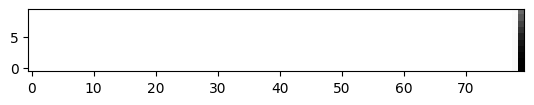

In [10]:
from scipy.stats import multivariate_normal
test = np.zeros(n_particles)
center = [400, 0]

for x in np.arange(Nx):
    for y in np.arange(Ny):
        test[x+y*Nx] = multivariate_normal.pdf([x,y], mean = center, cov = [[100, 0], [0, 100]])
test = einops.rearrange(test, "(y x) -> x y", y=Ny).transpose()
test = test / test.max() * 9000
plt.imshow(test, origin = 'lower', cmap='Greys')
plt.show()

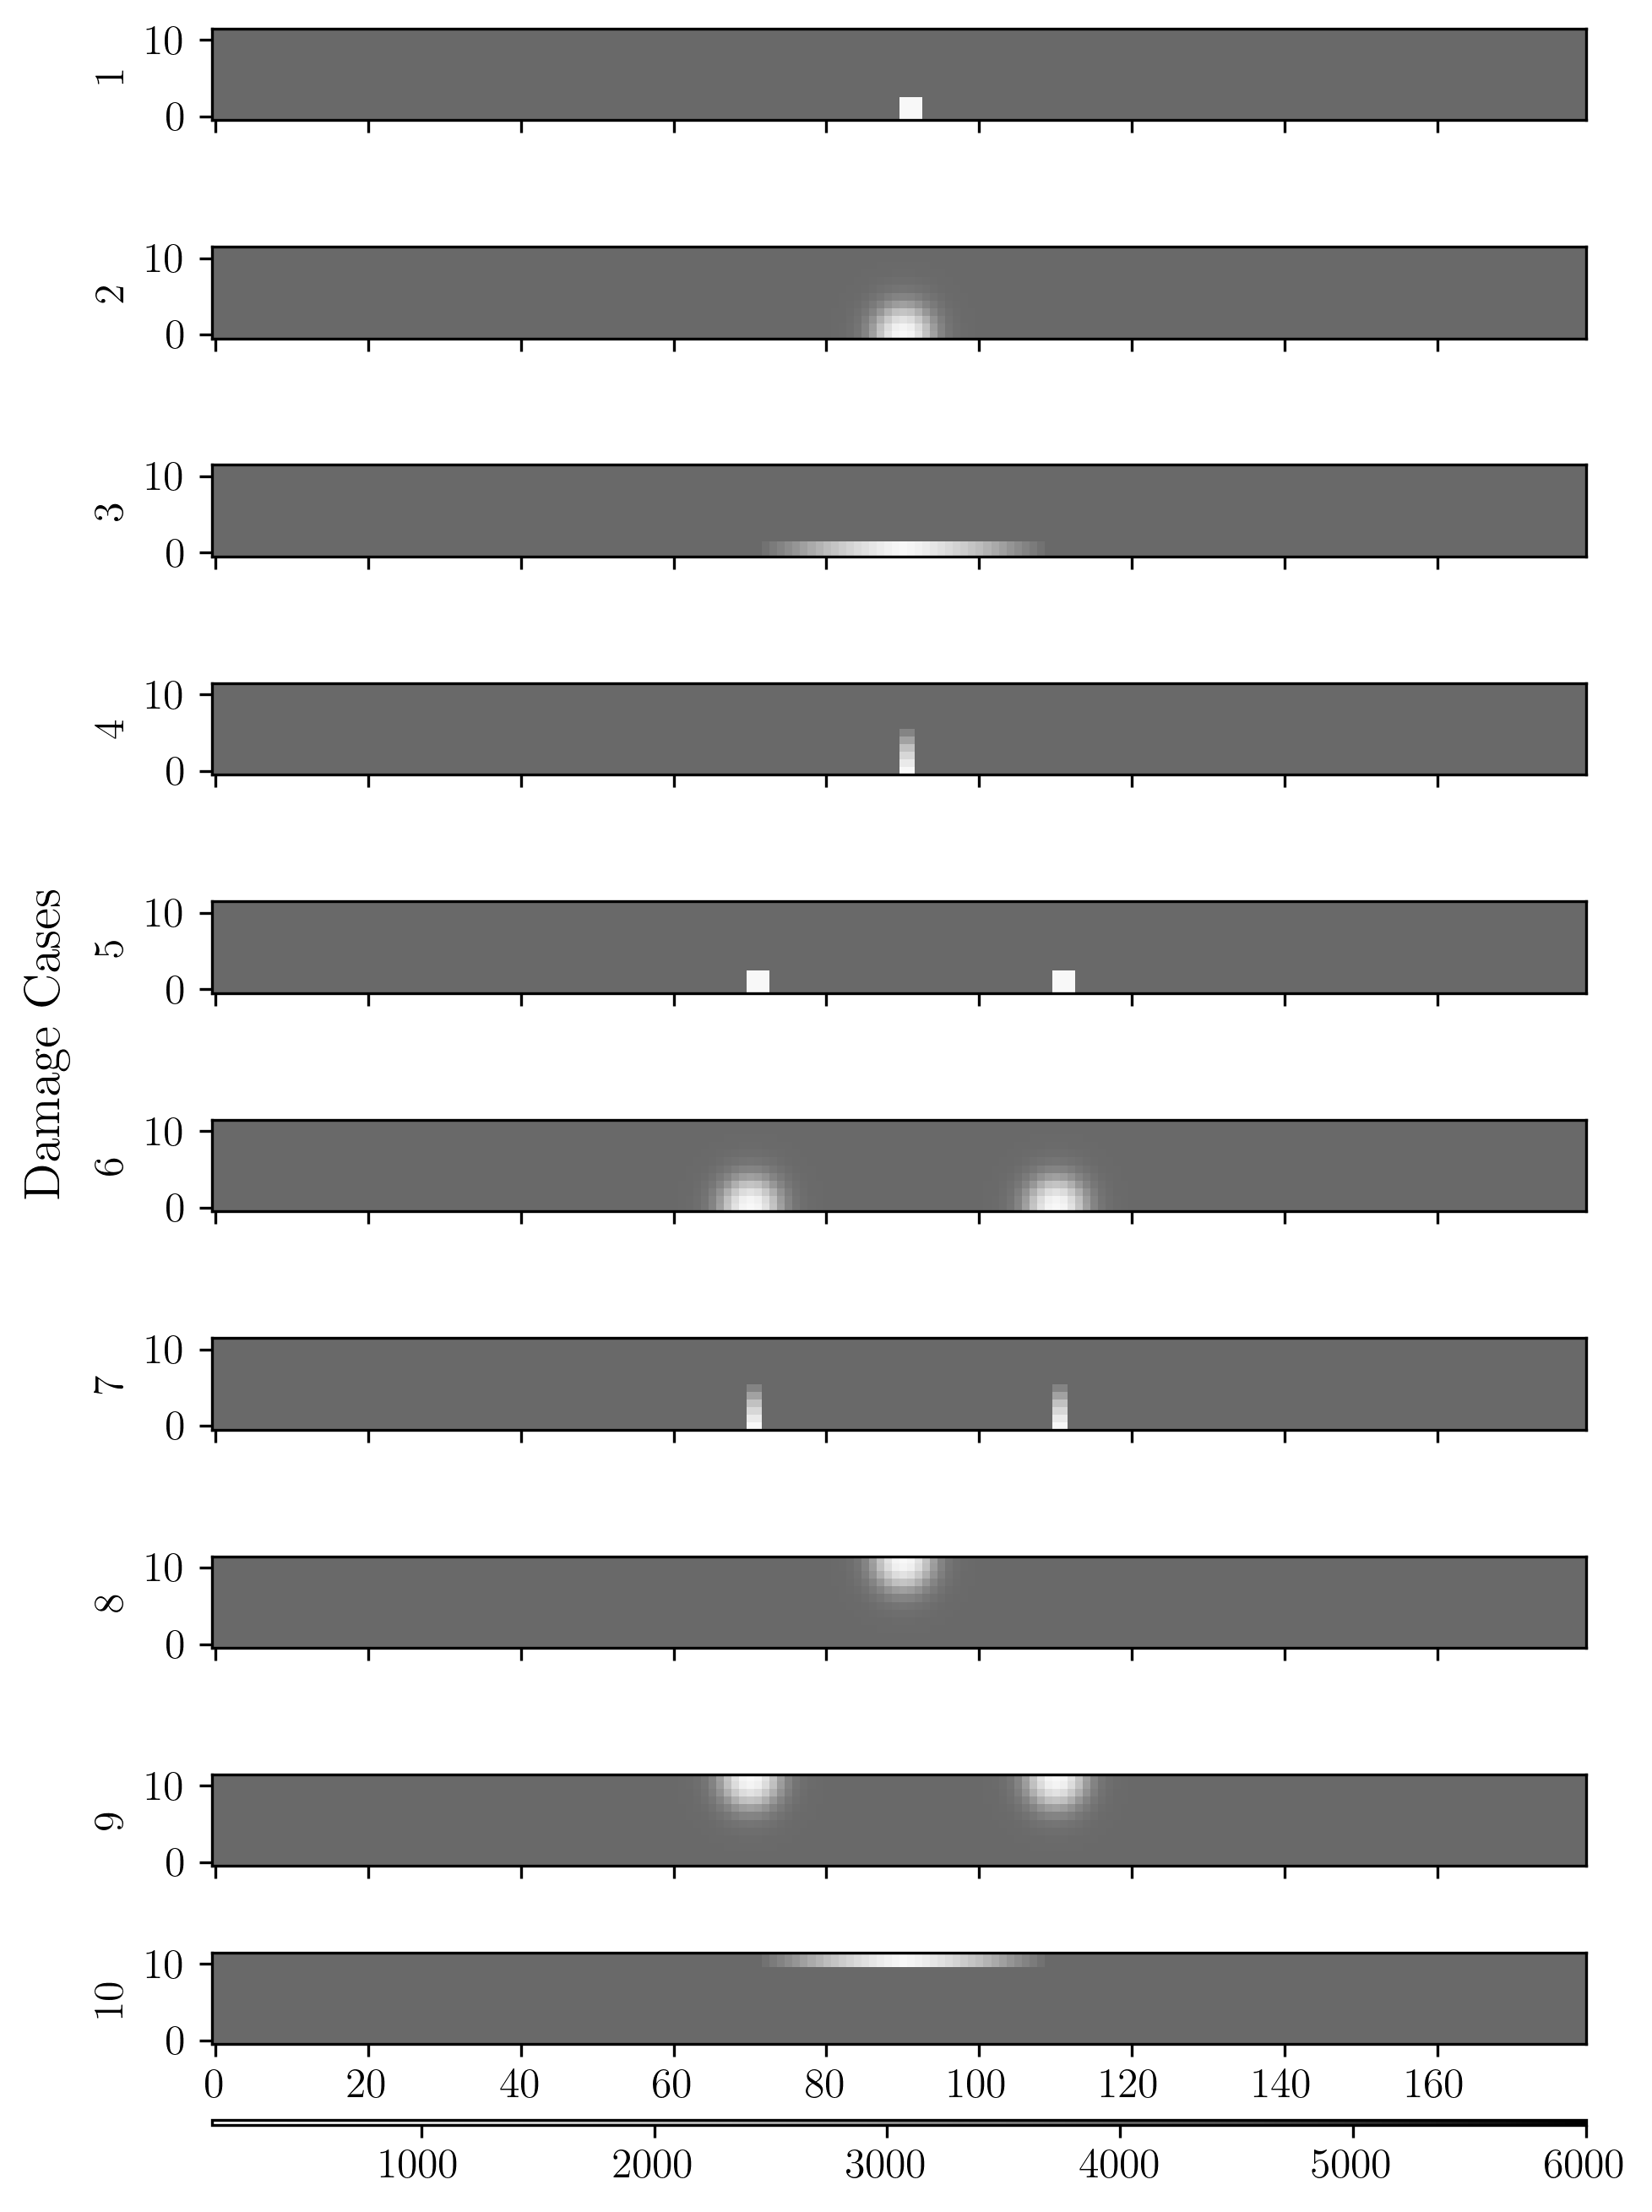

In [3]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 12}
matplotlib.rc('font', **font)


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]


filenames_1e4 = []
for name in filenames:
    if '10000' in name:
        filenames_1e4.append(name)



E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 180
Ny = 12
n_particles = Nx * Ny

E_d = np.zeros(n_particles) + 4000
E_g = np.zeros(n_particles) + 4000
E_h = np.zeros(n_particles) + 4000
E_v = np.zeros(n_particles) + 4000
E_d_m = np.zeros(n_particles) + 4000
E_g_m = np.zeros(n_particles) + 4000
E_v_m = np.zeros(n_particles) + 4000
E_gt = np.zeros(n_particles) + 4000
E_gt_m = np.zeros(n_particles) + 4000
E_ht = np.zeros(n_particles) + 4000


def discrete_damage(left, width, height):
    idx = np.array([])
    for row in np.arange(height):
        idx = np.concatenate((idx, np.arange(left+Nx*row, left+width+Nx*row)))
    
    return [int(i) for i in idx]

def gradient_damage(E, start, width, half_length, horizontal=True, E_start=400, E_stop=4000):
    interp = np.interp(np.arange(half_length), [0, half_length-1], [E_start, E_stop])
    if horizontal:
        for row in np.arange(width):
            E[np.arange(start+Nx*row, start+half_length+Nx*row)] = interp
            E[np.arange(start+Nx*row, start-half_length+Nx*row, -1)] = interp
    else:
        for col in np.arange(width):
            E[np.arange(start+col, start+col+half_length*Nx, Nx)] = interp

def gaussian_damage(E, center, start=3600, cov=[[7, 0], [0, 7]]):
    x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))
    coords = np.column_stack([x.ravel(), y.ravel()])

    dmg = multivariate_normal.pdf(coords, mean=center, cov=cov)
    dmg = dmg.reshape(E.shape)
    
    dmg = dmg / dmg.max() * start
    E = E - dmg
    return E

E_d_damage_idx = discrete_damage(90, 3, 3)
E_d[E_d_damage_idx] = np.repeat(400, len(E_d_damage_idx))

E_d_m_damage_idx = np.concatenate((discrete_damage(70, 3, 3), discrete_damage(110, 3, 3)))
E_d_m[E_d_m_damage_idx] = np.repeat(400, len(E_d_m_damage_idx))

gradient_damage(E_h, 90, 2, 20)
gradient_damage(E_ht, 2070-Nx, 2, 20)

gradient_damage(E_v, 90, 2, 7, horizontal=False)
gradient_damage(E_v_m, 70, 2, 7, horizontal=False)
gradient_damage(E_v_m, 110, 2, 7, horizontal=False)

E_g = gaussian_damage(E_g, [90, 0])
E_g_m = gaussian_damage(E_g_m, [70, 0])
E_g_m = gaussian_damage(E_g_m, [110, 0])
E_gt = gaussian_damage(E_gt, [90, 11])
E_gt_m = gaussian_damage(E_gt_m, [70, 11])
E_gt_m = gaussian_damage(E_gt_m, [110, 11])

E_d = einops.rearrange(E_d, "(y x) -> x y", y=Ny).transpose()
E_g = einops.rearrange(E_g, "(y x) -> x y", y=Ny).transpose()
E_h = einops.rearrange(E_h, "(y x) -> x y", y=Ny).transpose()
E_v = einops.rearrange(E_v, "(y x) -> x y", y=Ny).transpose()
E_d_m = einops.rearrange(E_d_m, "(y x) -> x y", y=Ny).transpose()
E_g_m = einops.rearrange(E_g_m, "(y x) -> x y", y=Ny).transpose()
E_v_m = einops.rearrange(E_v_m, "(y x) -> x y", y=Ny).transpose()
E_gt = einops.rearrange(E_gt, "(y x) -> x y", y=Ny).transpose()
E_gt_m = einops.rearrange(E_gt_m, "(y x) -> x y", y=Ny).transpose()
E_ht = einops.rearrange(E_ht, "(y x) -> x y", y=Ny).transpose()

fig, axs = plt.subplots(10,1, sharex=True, sharey=True, figsize=(7,11))


# fig.suptitle('True Undamaged Elastic Fields')
fig.supylabel('Damage Cases')

for i in range(10):
    axs[i].set_ylabel(i+1)

axs[0].imshow(E_d, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[1].imshow(E_g, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[1].set_title('True Damaged Elastic Field')

axs[2].imshow(E_h, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[2].set_title('True Damaged Elastic Field')

axs[3].imshow(E_v, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[3].set_title('True Damaged Elastic Field')

axs[4].imshow(E_d_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[4].set_title('True Damaged Elastic Field')

axs[5].imshow(E_g_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[5].set_title('True Damaged Elastic Field')

axs[6].imshow(E_v_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[6].set_title('True Damaged Elastic Field')

axs[7].imshow(E_gt, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[8].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)


im = axs[9].imshow(E_ht, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
divider = make_axes_locatable(axs[9])
cax = divider.append_axes("bottom", size="5%", pad=0.3)
fig.colorbar(im, cax=cax, orientation='horizontal')

# im1 = axs[2, 0].imshow(E_sensor, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
# axs[2, 0].set_title('Estimated Undamaged Field, Discrete Surface Observability')
# divider1 = make_axes_locatable(axs[2, 0])
# cax1 = divider1.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im1, cax=cax1, orientation='horizontal')

# im2 = axs[2, 1].imshow(E_sensor_damaged, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
# axs[2, 1].set_title('Estimated Damaged Field, Discrete Surface Observability')
# divider2 = make_axes_locatable(axs[2, 1])
# cax2 = divider2.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im2, cax=cax2, orientation='horizontal')
plt.show()
    

    


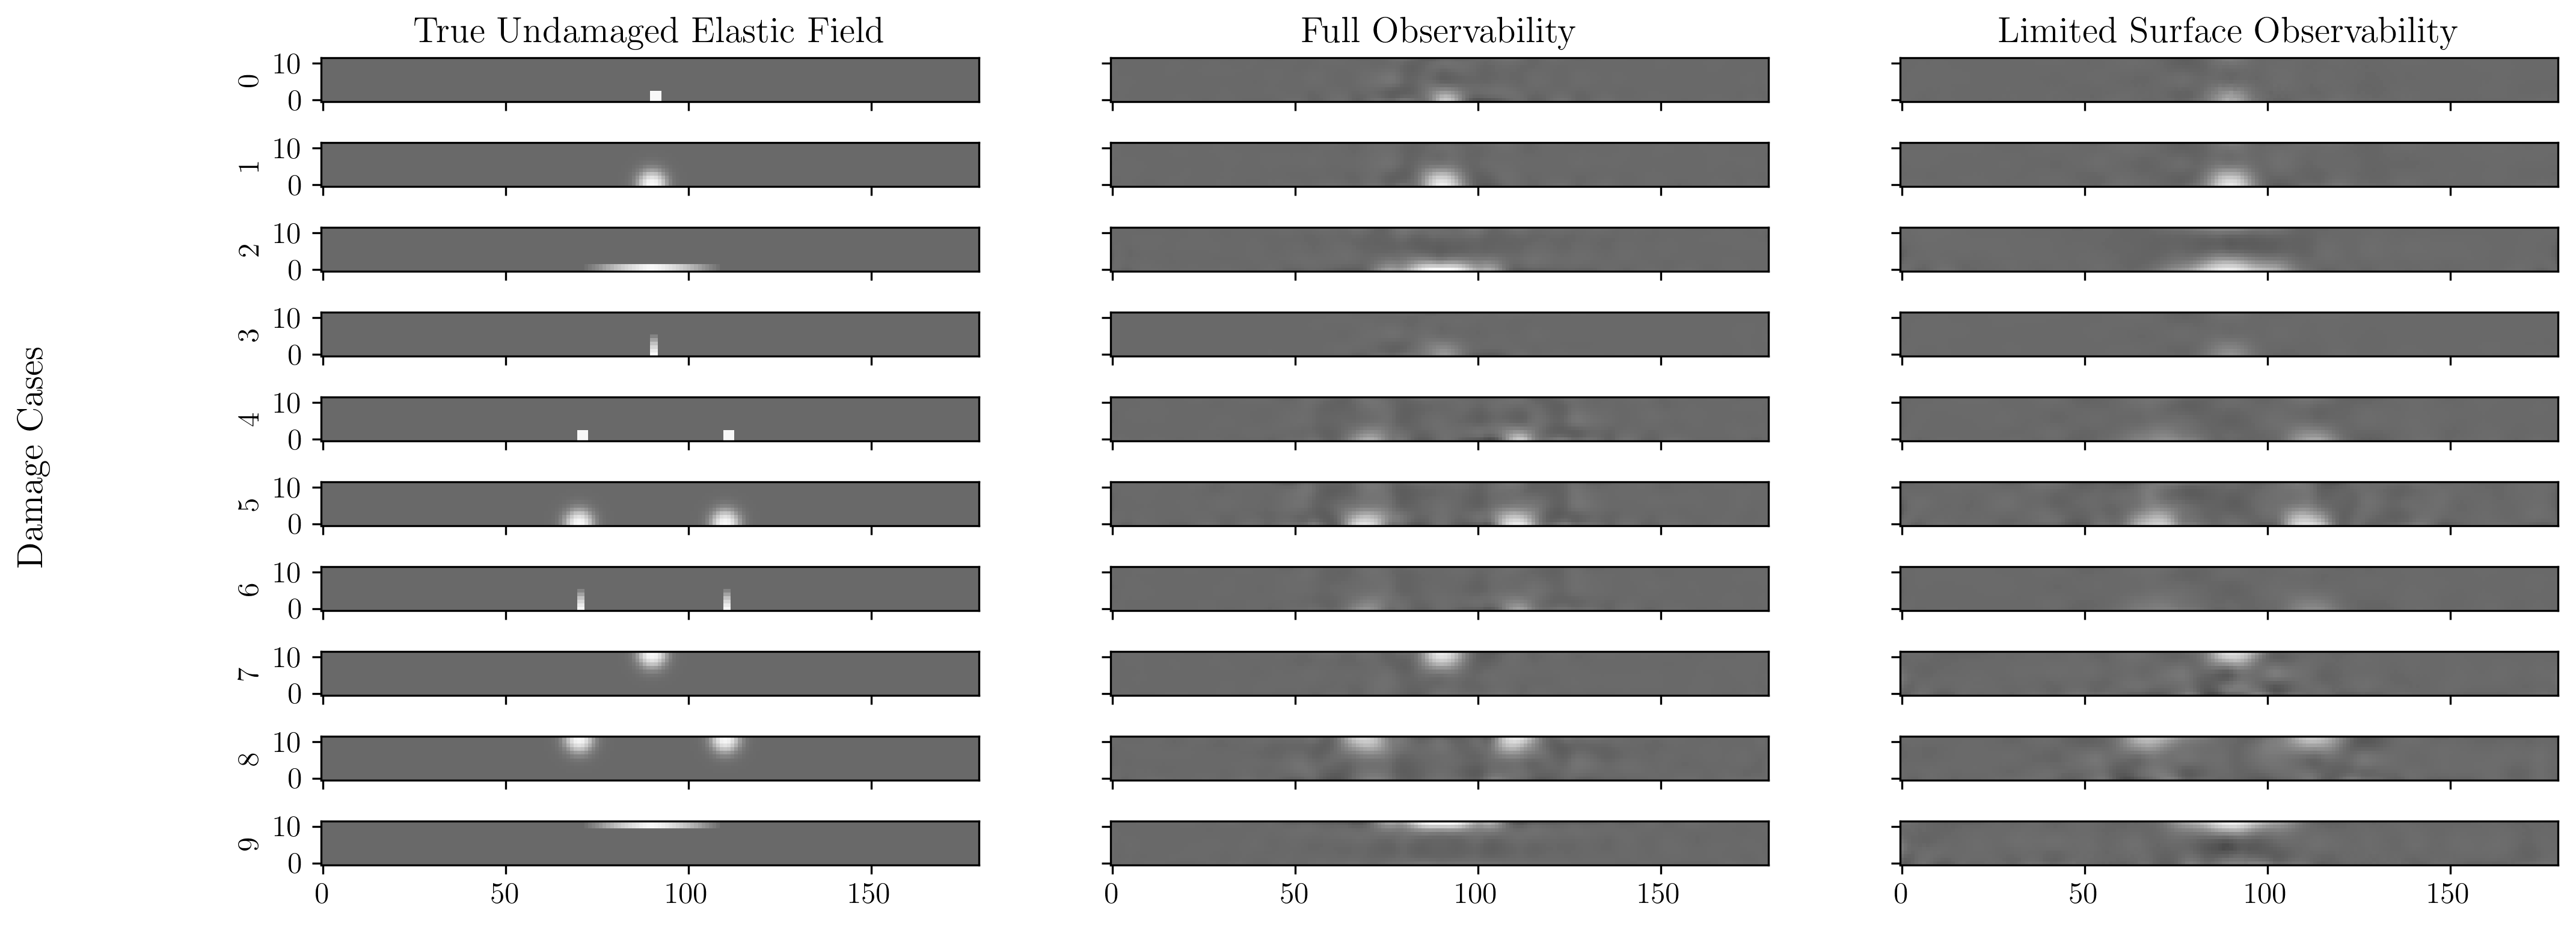

In [4]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 12}
matplotlib.rc('font', **font)


fig, axs = plt.subplots(10,3, sharex=True, sharey=True, figsize=(16,6))


fig.supylabel('Damage Cases')

axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)


im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 180
Ny = 12
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

for k, case in enumerate(cases):
    obs_cases = [
        'r_c_'+case+'_full.json',
        'r_c_'+case+'_sensor.json'
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(n_particles)
        match = re.search(pattern, name)
        n_blocks_x = 180
        n_blocks_y = 12
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        for i in range(Nx):
            for j in range(Ny):
                block_index_x = i // block_nx
                block_index_y = j // block_ny
                E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[k, 0].set_ylabel(f"{k}")
axs[0, 1].set_title('Full Observability')
axs[0, 2].set_title('Limited Surface Observability')
plt.show()
    

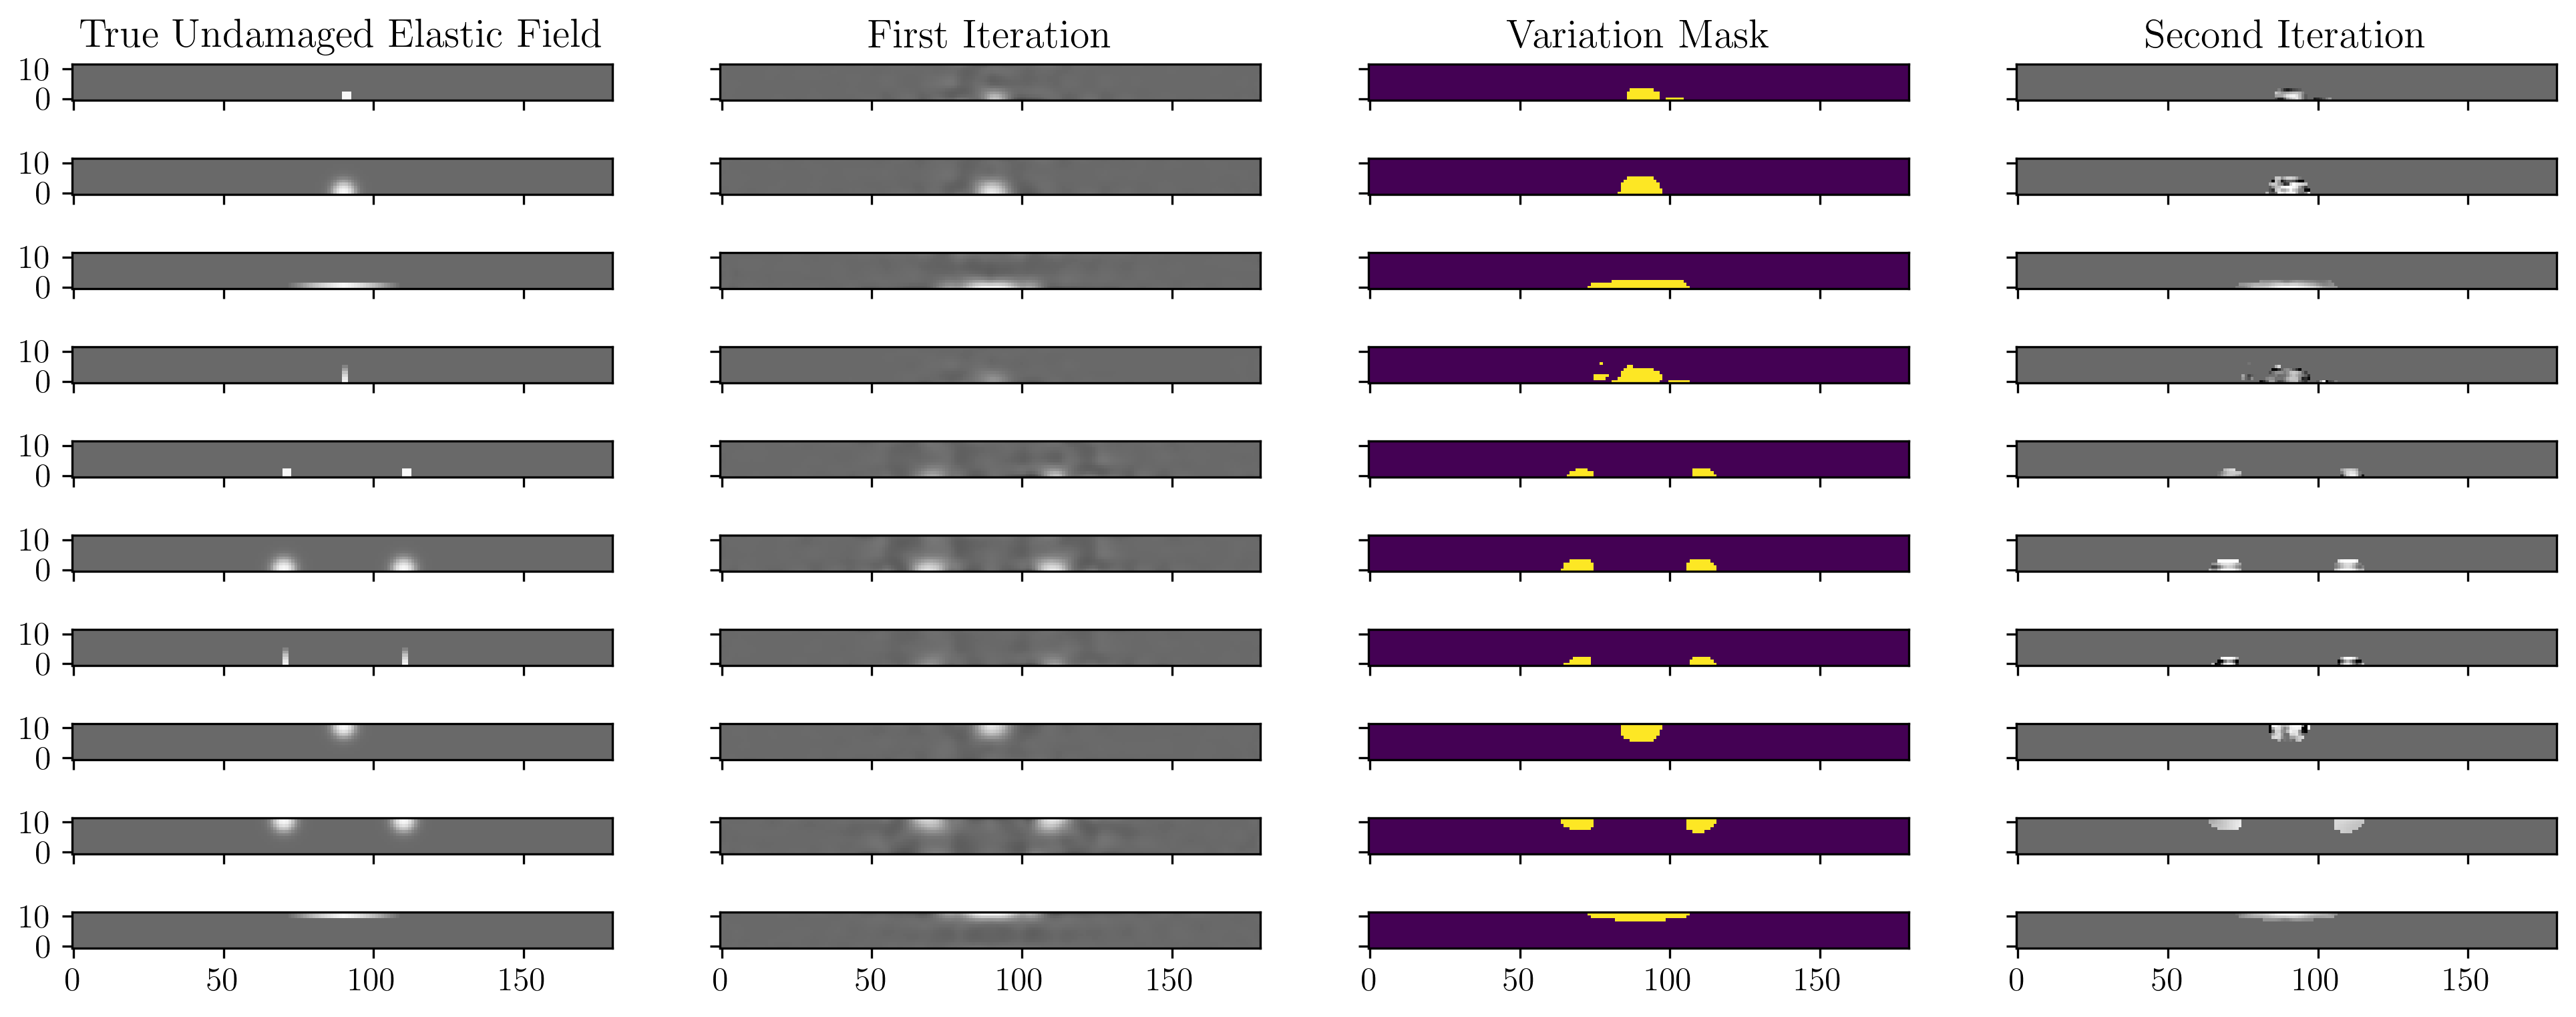

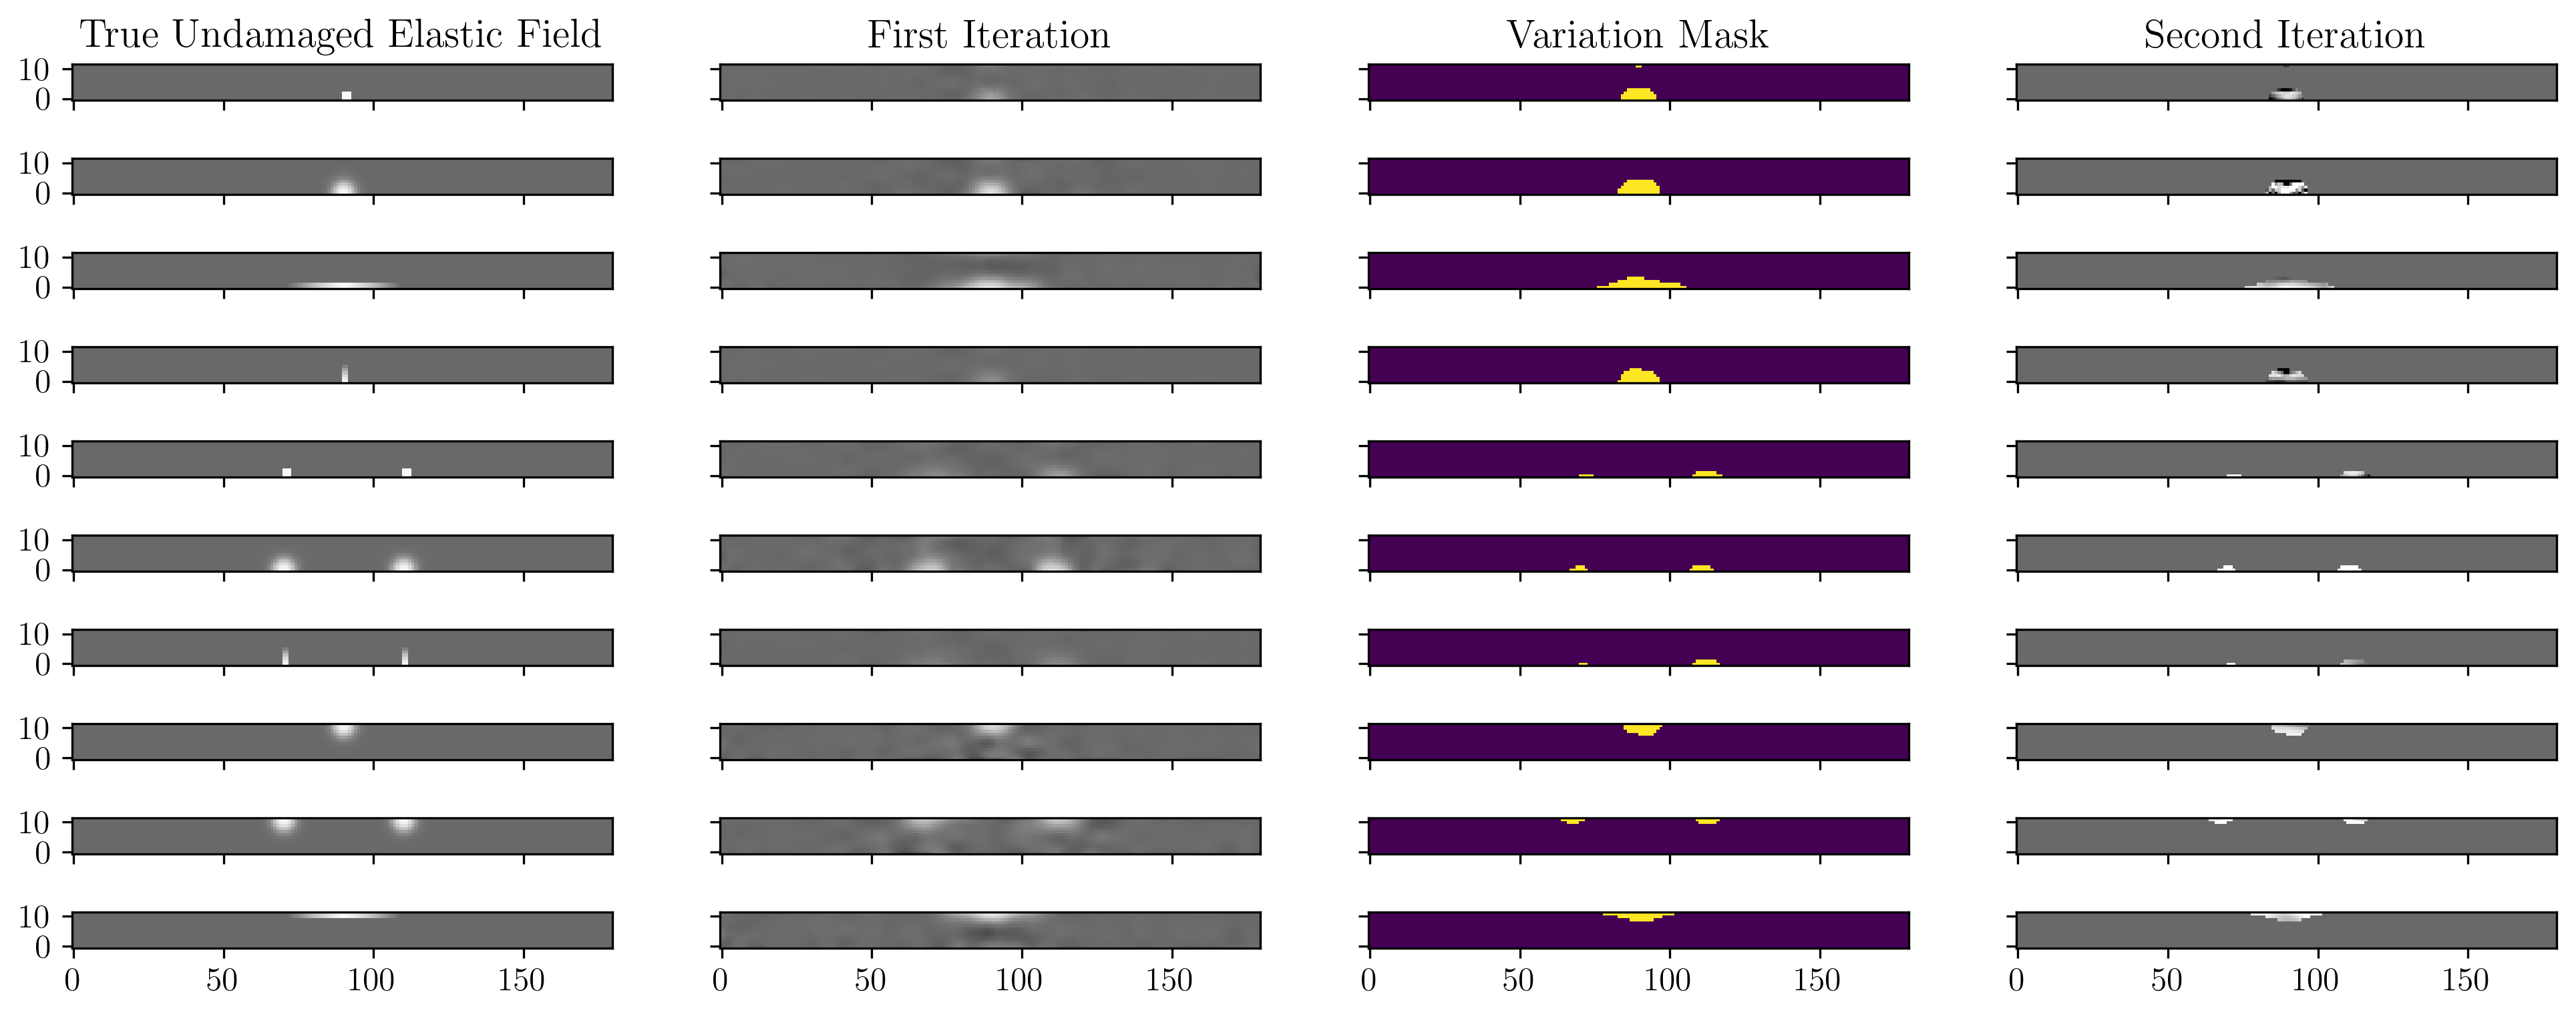

In [5]:
import matplotlib.pyplot as plt
import matplotlib, os
matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 12}
matplotlib.rc('font', **font)

# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 180
Ny = 12
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

def stable_regions(x, reference, n_percent=10, m=2):
    deviation = np.abs(x - reference)
    n_elements = int(len(deviation) * (n_percent / 100))
    
    # Get indices of the lowest n% deviations
    stable_indices = np.argsort(deviation)[:n_elements]
    
    # Compute the standard deviation of these stable elements
    stable_std = np.std(deviation[stable_indices])
    
    # Identify indices where deviation exceeds m times the stable standard deviation
    threshold = m * stable_std
    exceed_indices = np.where(deviation > threshold)[0]

    return stable_indices, stable_std, exceed_indices

for obs in ["full", "sensor"]:
    fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


    axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[0, 0].set_title('True Undamaged Elastic Field')

    axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

    axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

    axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

    axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

    axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

    axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

    axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

    axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)


    im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=100, vmax = 6000)


    for k, case in enumerate(cases):
        obs_cases = [
            f"r_c_{case}_{obs}.json",
        ]
        for l, obs_case in enumerate(obs_cases):
            with open(obs_case) as json_file:
                result = json.load(json_file)['E_hist'][-1]   
            E = np.zeros(n_particles)
            match = re.search(pattern, name)
            n_blocks_x = 180
            n_blocks_y = 12
            n_blocks = n_blocks_y * n_blocks_x
            block_nx = int(Nx / n_blocks_x)
            block_ny = int(Ny / n_blocks_y)

            for i in range(Nx):
                for j in range(Ny):
                    block_index_x = i // block_nx
                    block_index_y = j // block_ny
                    E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
            E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
            
            axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

        stable, std, exceed = stable_regions(np.array(result), 4e3, n_percent=50, m=1e2)
        mask = np.zeros(n_particles)
        mask[exceed] = 100
        mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()
        axs[k, l + 2].imshow(mask, origin='lower')
        
        it2 = f"r_c_mask_{case}_{obs}_start_10.json"
        with open(it2) as json_file:
                result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(n_particles) + 4e3
        E[exceed] =  result
        E_rearrange = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        axs[k, l + 3].imshow(E_rearrange, origin='lower', cmap='Greys', vmin=100, vmax = 6000)


    axs[0, 1].set_title('First Iteration')
    axs[0, 2].set_title('Variation Mask')
    axs[0, 3].set_title('Second Iteration')
    plt.show()




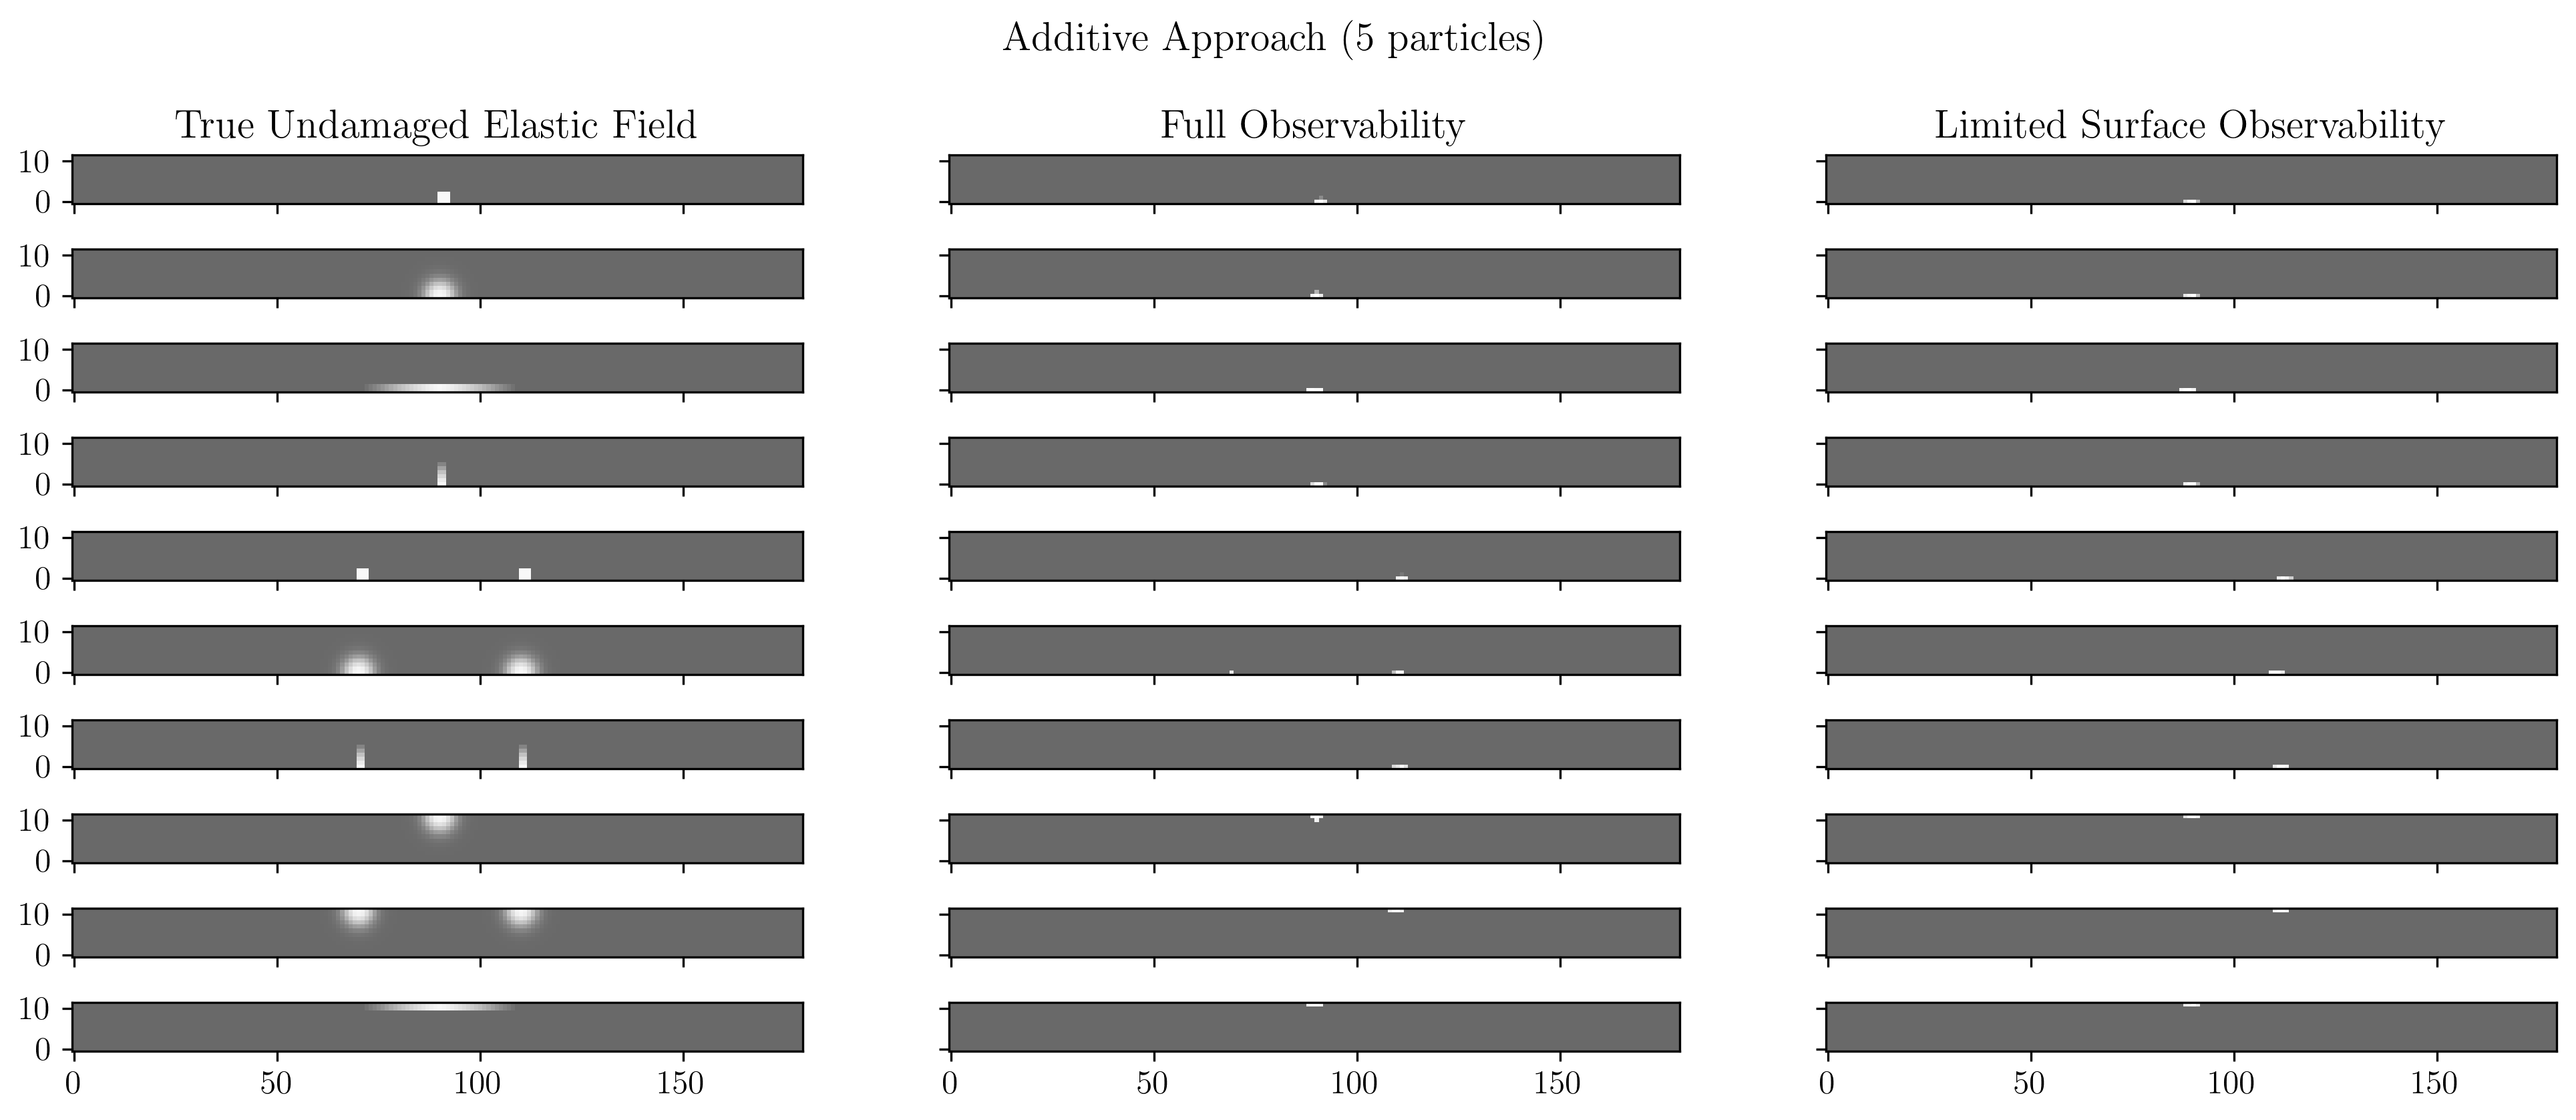

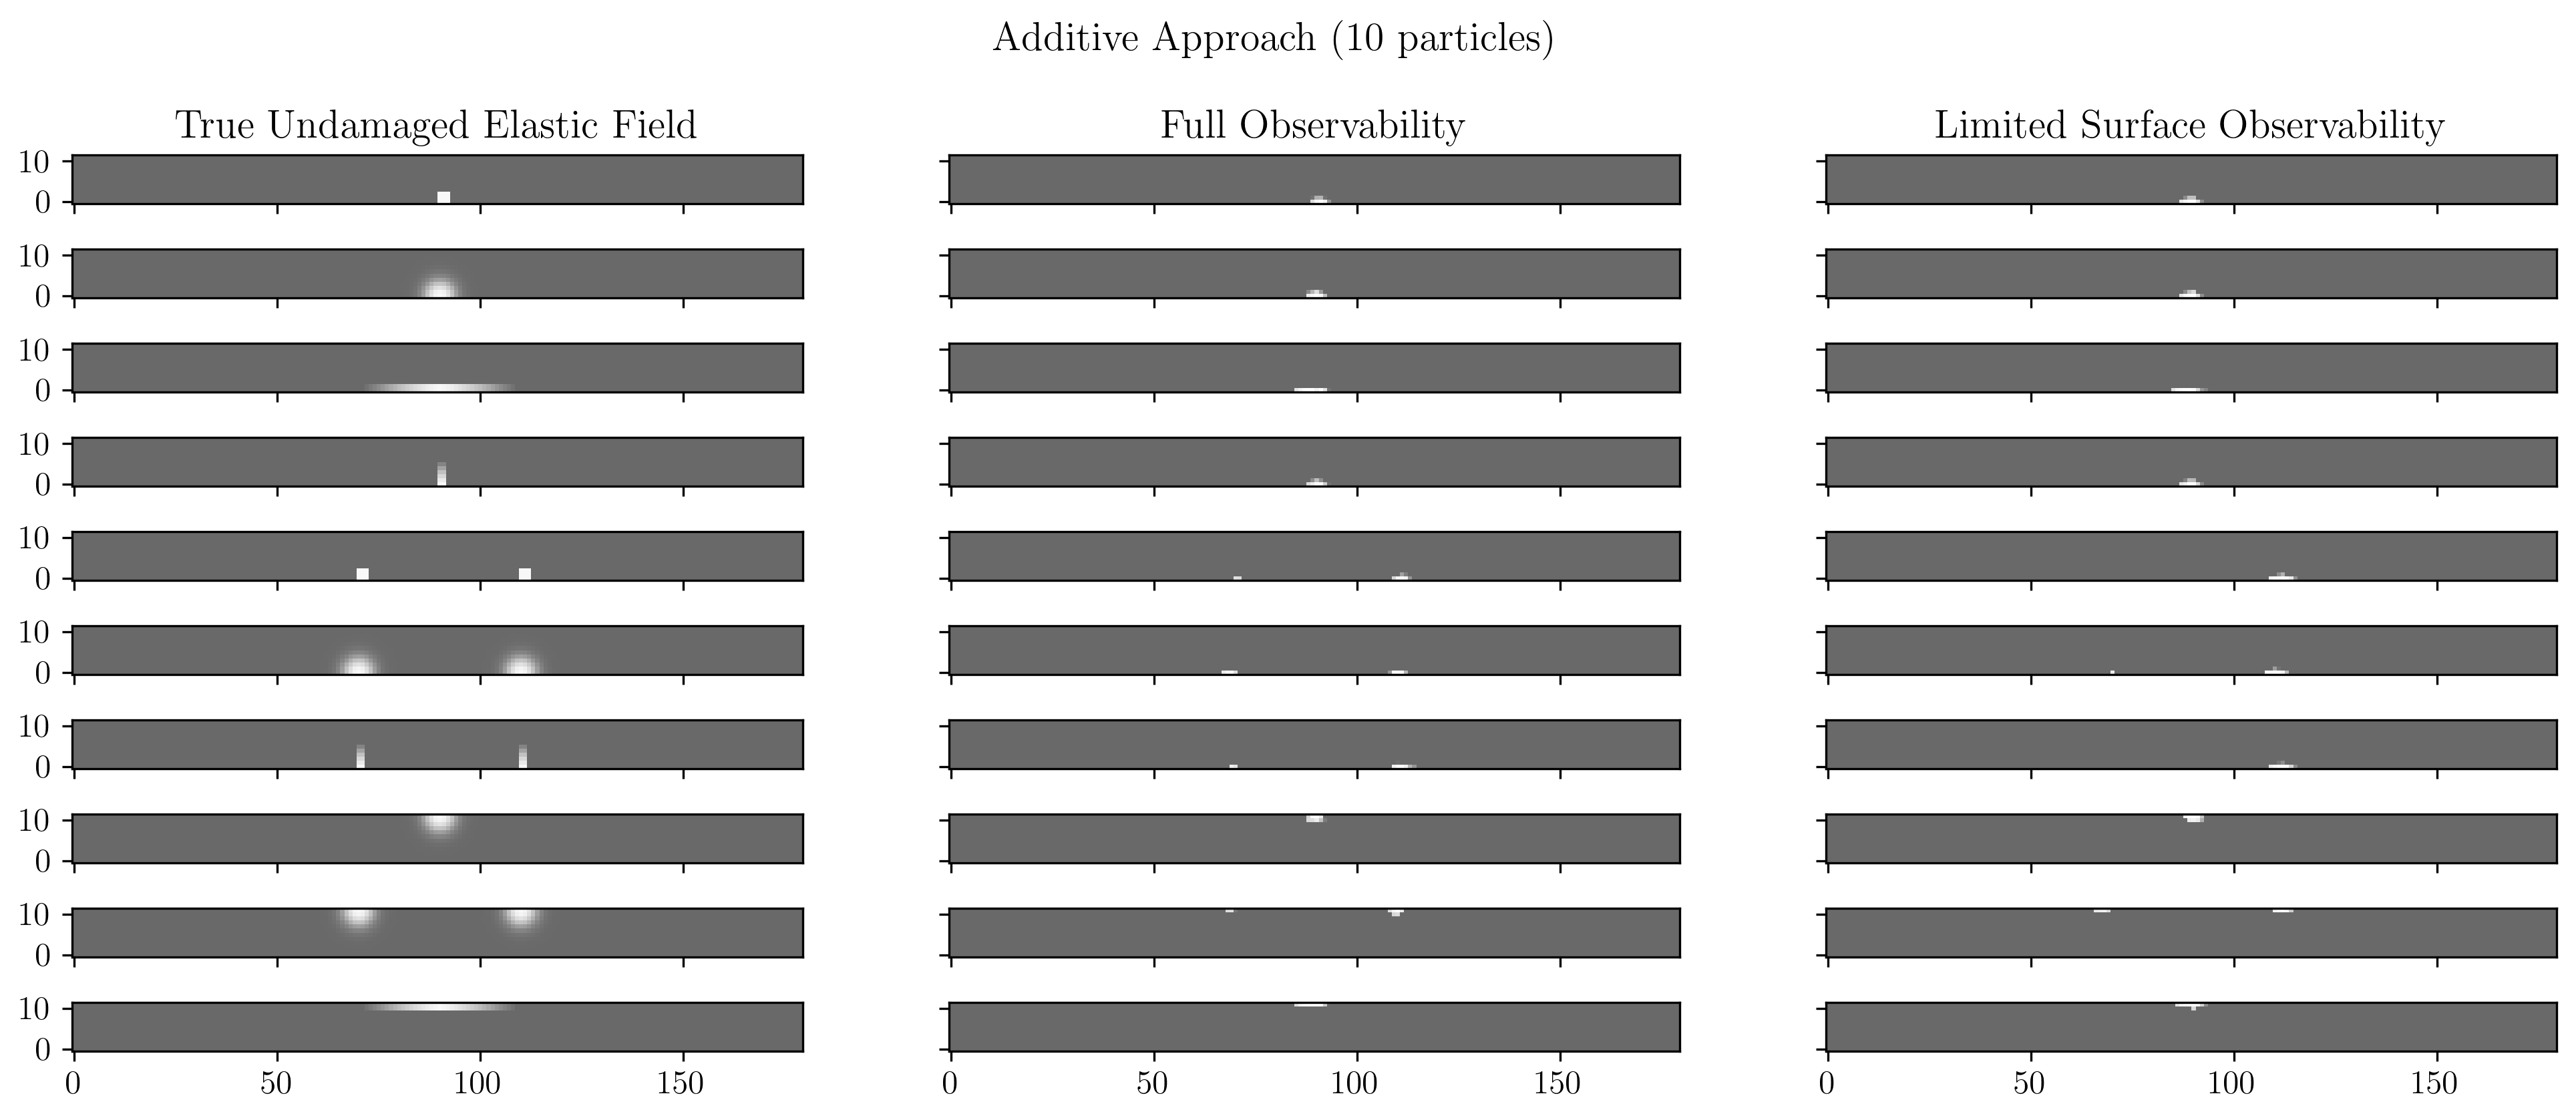

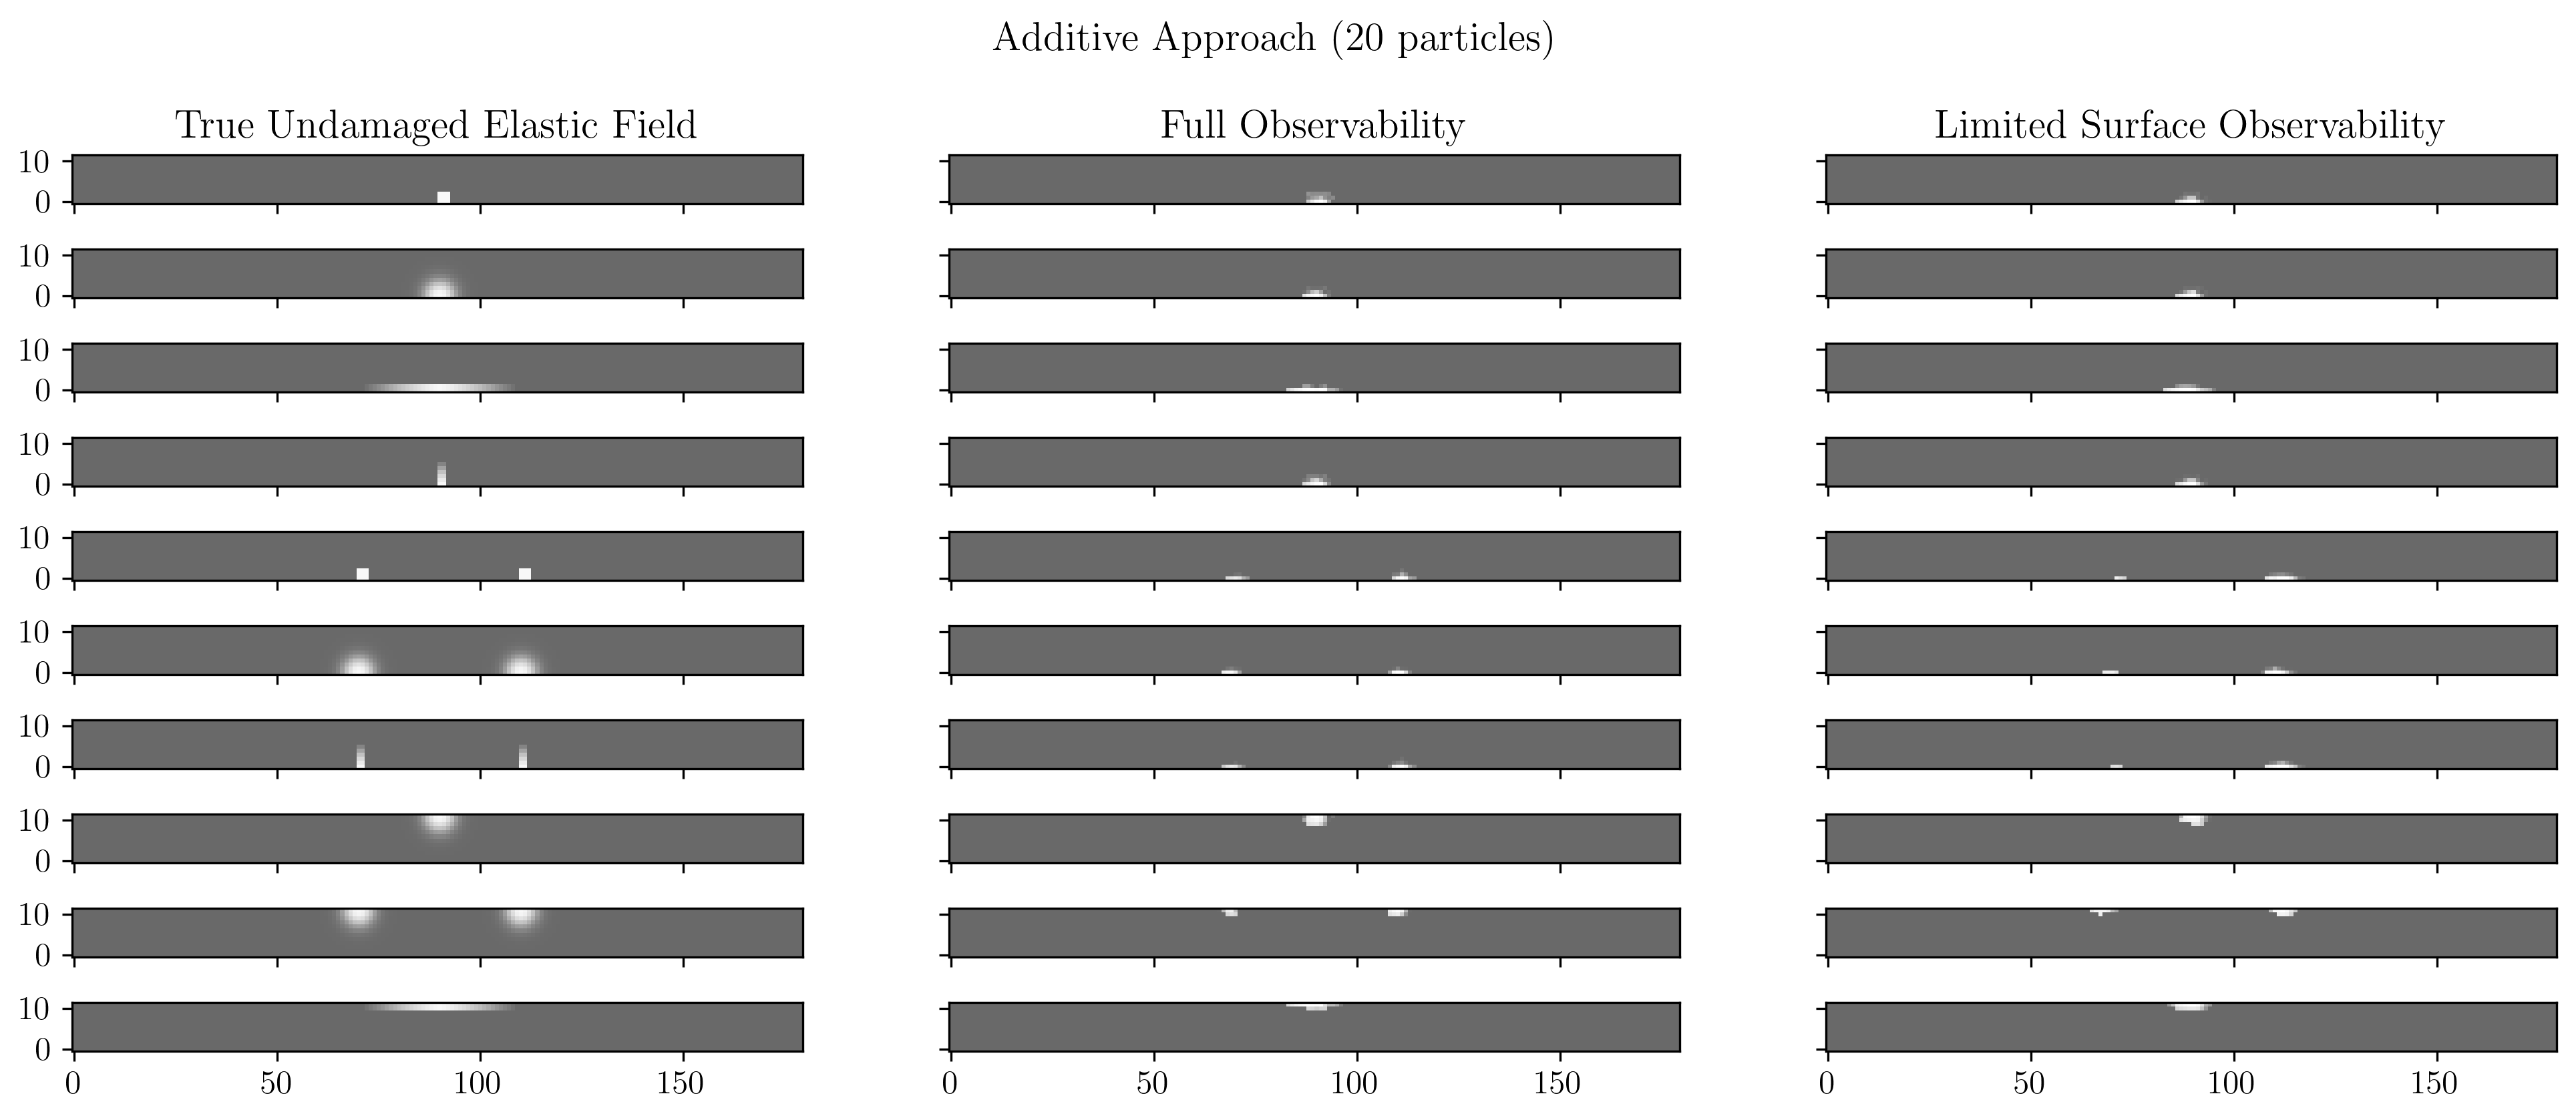

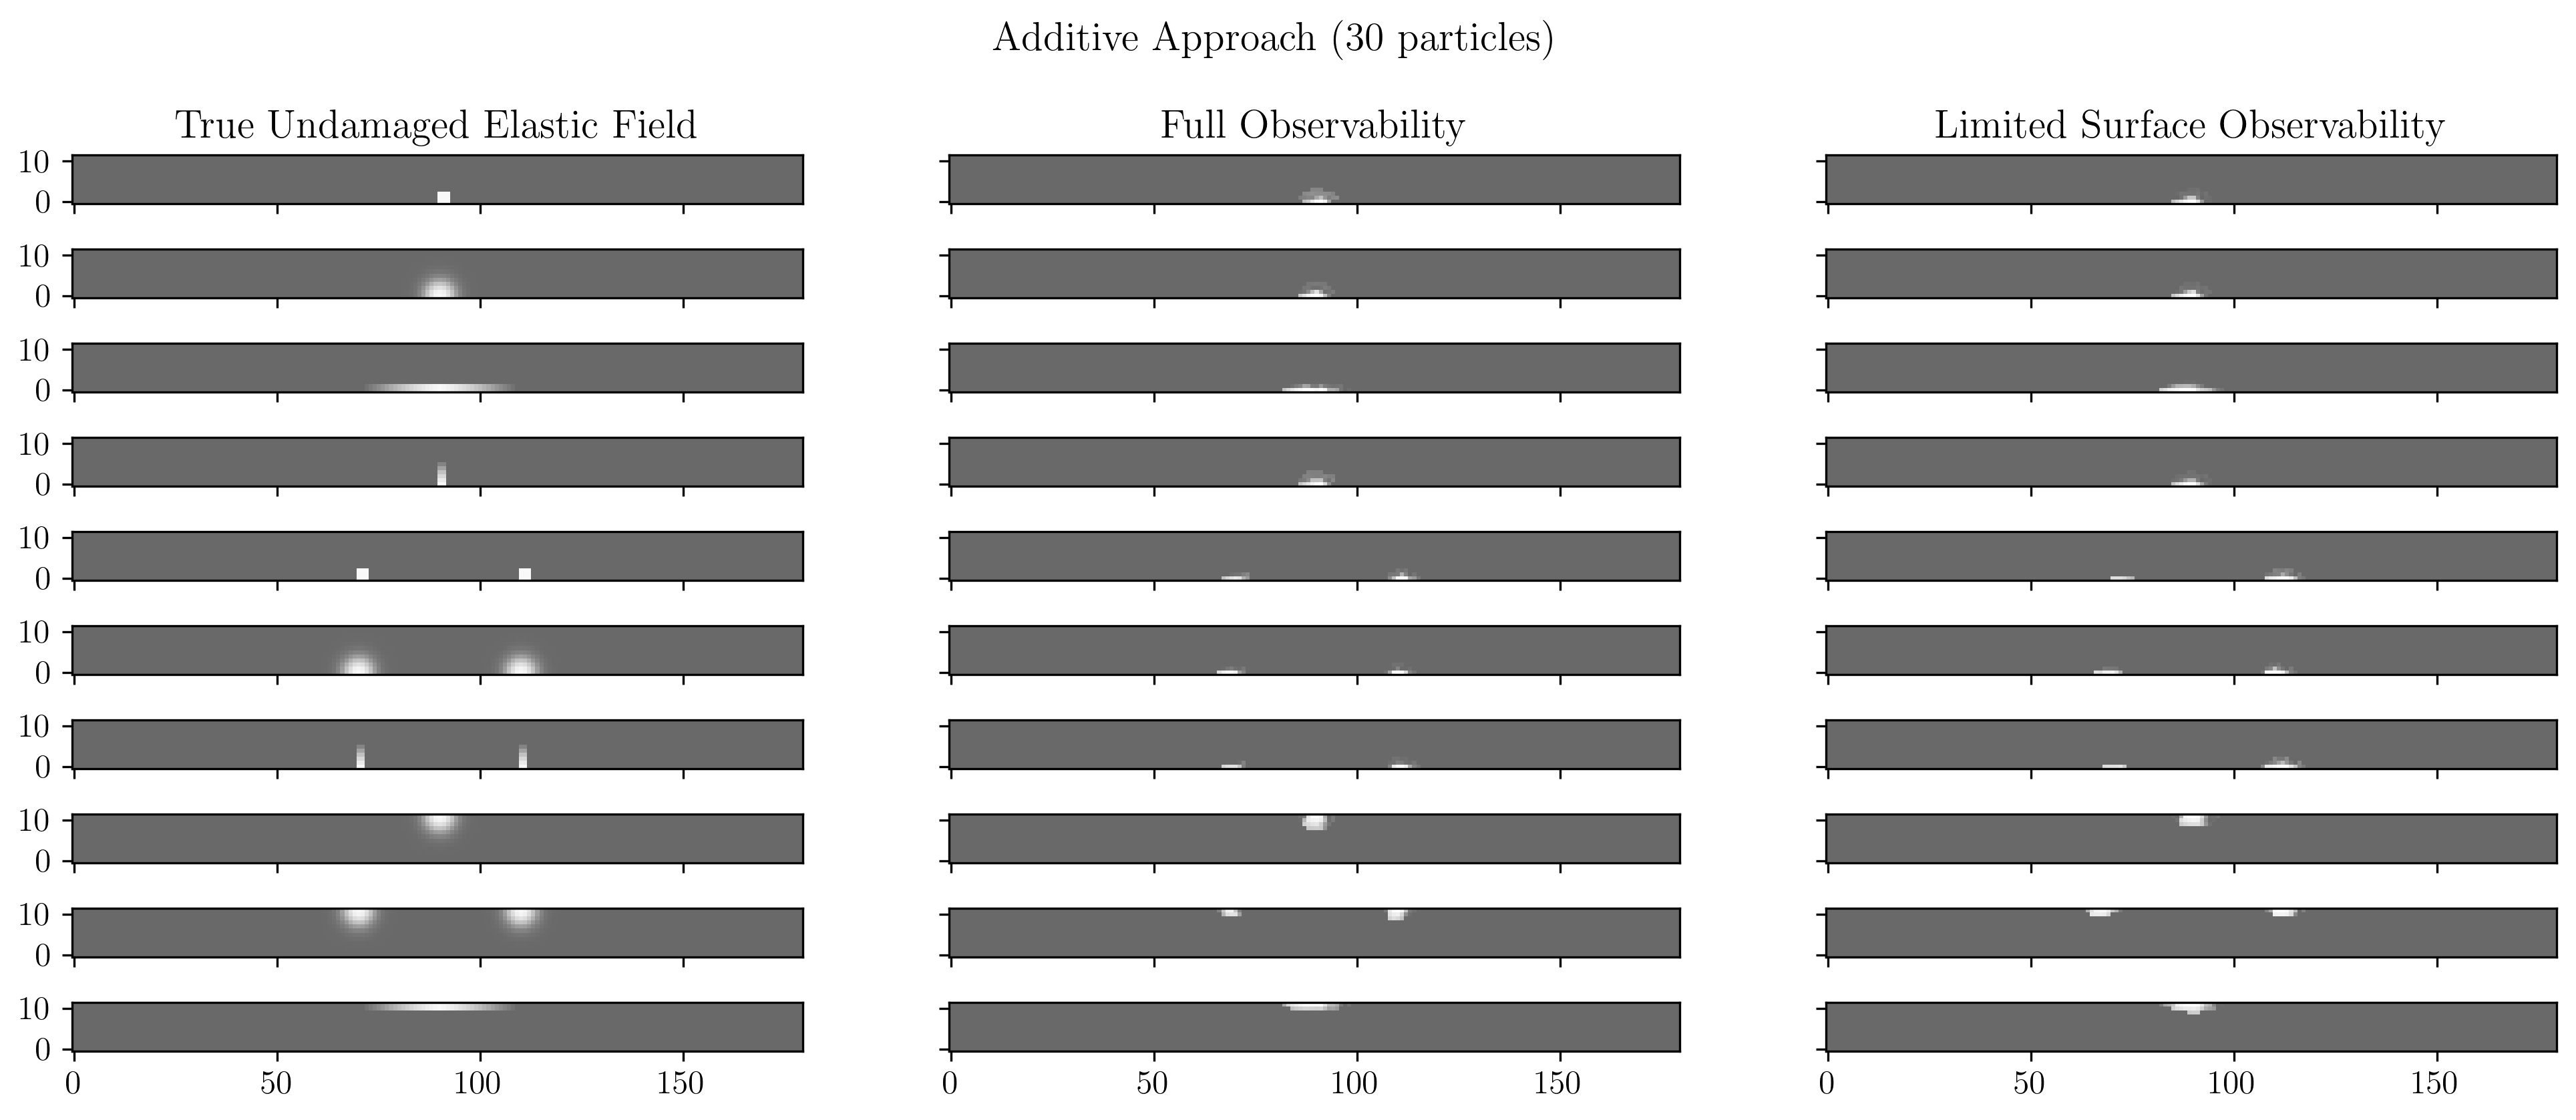

In [15]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 12}
matplotlib.rc('font', **font)

# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]
filenames2 = []
for file in filenames:
    if "add" in file and "p1" in file:
        filenames2.append(file)
filenames = filenames2


Nx = 180
Ny = 12
n_particles = Nx * Ny
init_e = 4e3

for part in ["p1"]:
    for n_search in ["5", "10", "20", "30"]:
        fig, axs = plt.subplots(10,3, sharex=True, sharey=True, figsize=(16,6))


        fig.suptitle(f'Additive Approach ({n_search} particles)')

        axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[0, 0].set_title('True Undamaged Elastic Field')

        axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

        axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

        axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

        axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

        axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

        axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

        axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

        axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)


        im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        for k, case in enumerate(cases):


            obs_cases = [
                f'r_c_add_{case}_full_{n_search}_{part}.json',
            ]
            for l, obs_case in enumerate(obs_cases):
                with open(obs_case) as json_file:
                    result = json.load(json_file)
                E = np.zeros(n_particles) + init_e
                n_blocks_x = Nx
                n_blocks_y = Ny
                n_blocks = n_blocks_y * n_blocks_x
                block_nx = int(Nx / n_blocks_x)
                block_ny = int(Ny / n_blocks_y)

                n_locked = len(result["locked_values"])
                # E[np.array(result["locked_indices"])] = np.array(result["locked_values"])
                
                # scale linearly from 100 to 4000
                locked_values = np.array(result["locked_values"])
                locked_values = 100 + (locked_values-locked_values.min())*(4000-100)/(locked_values.max()-locked_values.min())
                E[np.array(result["locked_indices"])] = locked_values
                E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
                
                axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

            obs_cases = [
                f'r_c_add_{case}_sensor_{n_search}_{part}.json',
            ]
            for l, obs_case in enumerate(obs_cases):
                with open(obs_case) as json_file:
                    result = json.load(json_file)
                E = np.zeros(n_particles) + init_e
                n_blocks_x = Nx
                n_blocks_y = Ny
                n_blocks = n_blocks_y * n_blocks_x
                block_nx = int(Nx / n_blocks_x)
                block_ny = int(Ny / n_blocks_y)
                n_locked = len(result["locked_values"])
                # E[np.array(result["locked_indices"])] = np.array(result["locked_values"])

                # scale linearly from 100 to 4000
                locked_values = np.array(result["locked_values"])
                locked_values = 100 + (locked_values-locked_values.min())*(4000-100)/(locked_values.max()-locked_values.min())
                E[np.array(result["locked_indices"])] = locked_values
                E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
                
                axs[k, l + 2].imshow(E, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

            # mask = np.zeros(n_particles)
            # mask[exceed] = 100
            # mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()
            # axs[k, l + 2].imshow(mask, origin='lower')



        axs[0, 1].set_title('Full Observability')
        axs[0, 2].set_title('Limited Surface Observability')
        # axs[0, 3].set_title('Second Iteration')
        plt.show()




In [ ]:
# import os
# import glob

# # Specify the directory (use '.' for current directory)
# directory = '.'

# # Pattern to match files ending with 'p2.json'
# pattern = os.path.join(directory, '*p2.json')

# # Find matching files
# files = glob.glob(pattern)

# # Delete each file
# for file in files:
#     try:
#         os.remove(file)
#         print(f"Deleted: {file}")
#     except Exception as e:
#         print(f"Error deleting {file}: {e}")

Deleted: .\r_c_add_dm_full_10_p2.json
Deleted: .\r_c_add_dm_full_20_p2.json
Deleted: .\r_c_add_dm_full_30_p2.json
Deleted: .\r_c_add_dm_full_5_p2.json
Deleted: .\r_c_add_dm_sensor_20_p2.json
Deleted: .\r_c_add_d_full_10_p2.json
Deleted: .\r_c_add_d_full_20_p2.json
Deleted: .\r_c_add_d_full_30_p2.json
Deleted: .\r_c_add_d_full_5_p2.json
Deleted: .\r_c_add_d_sensor_20_p2.json
Deleted: .\r_c_add_d_sensor_30_p2.json
Deleted: .\r_c_add_gm_full_10_p2.json
Deleted: .\r_c_add_gm_full_20_p2.json
Deleted: .\r_c_add_gm_full_30_p2.json
Deleted: .\r_c_add_gm_sensor_30_p2.json
Deleted: .\r_c_add_gtm_full_10_p2.json
Deleted: .\r_c_add_gtm_full_20_p2.json
Deleted: .\r_c_add_gtm_full_30_p2.json
Deleted: .\r_c_add_gtm_full_5_p2.json
Deleted: .\r_c_add_gtm_sensor_20_p2.json
Deleted: .\r_c_add_gtm_sensor_30_p2.json
Deleted: .\r_c_add_gt_full_10_p2.json
Deleted: .\r_c_add_gt_full_30_p2.json
Deleted: .\r_c_add_gt_full_5_p2.json
Deleted: .\r_c_add_gt_sensor_30_p2.json
Deleted: .\r_c_add_gt_sensor_5_p2.json
D

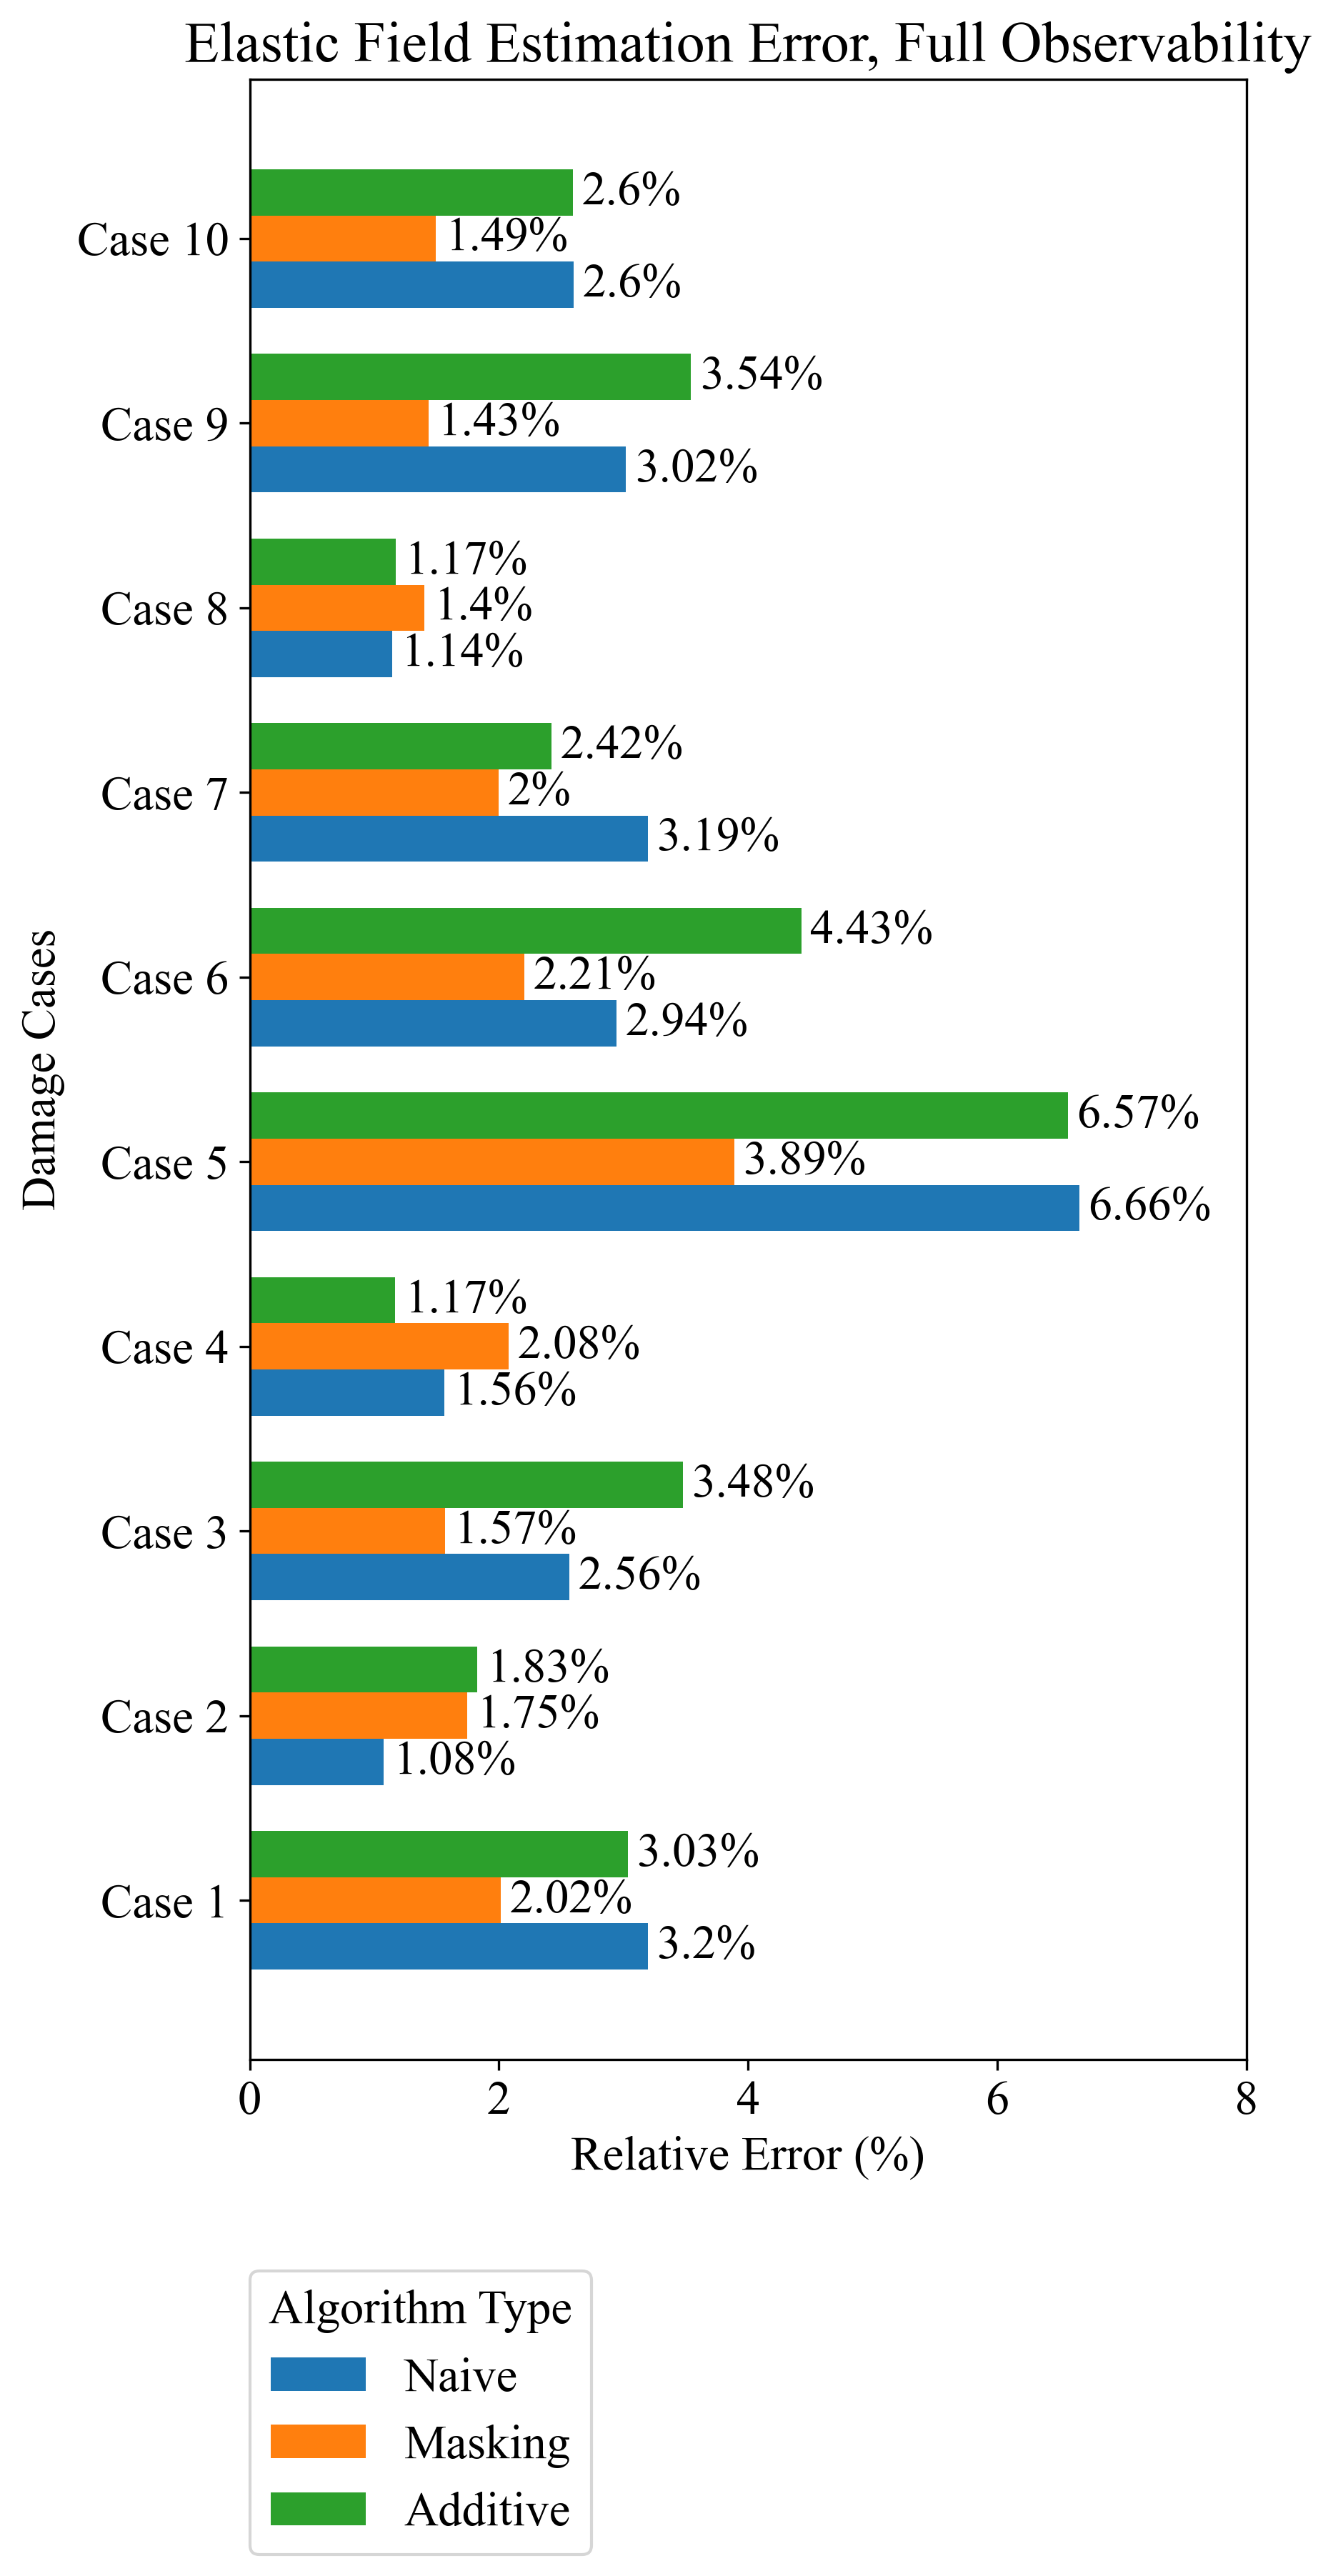

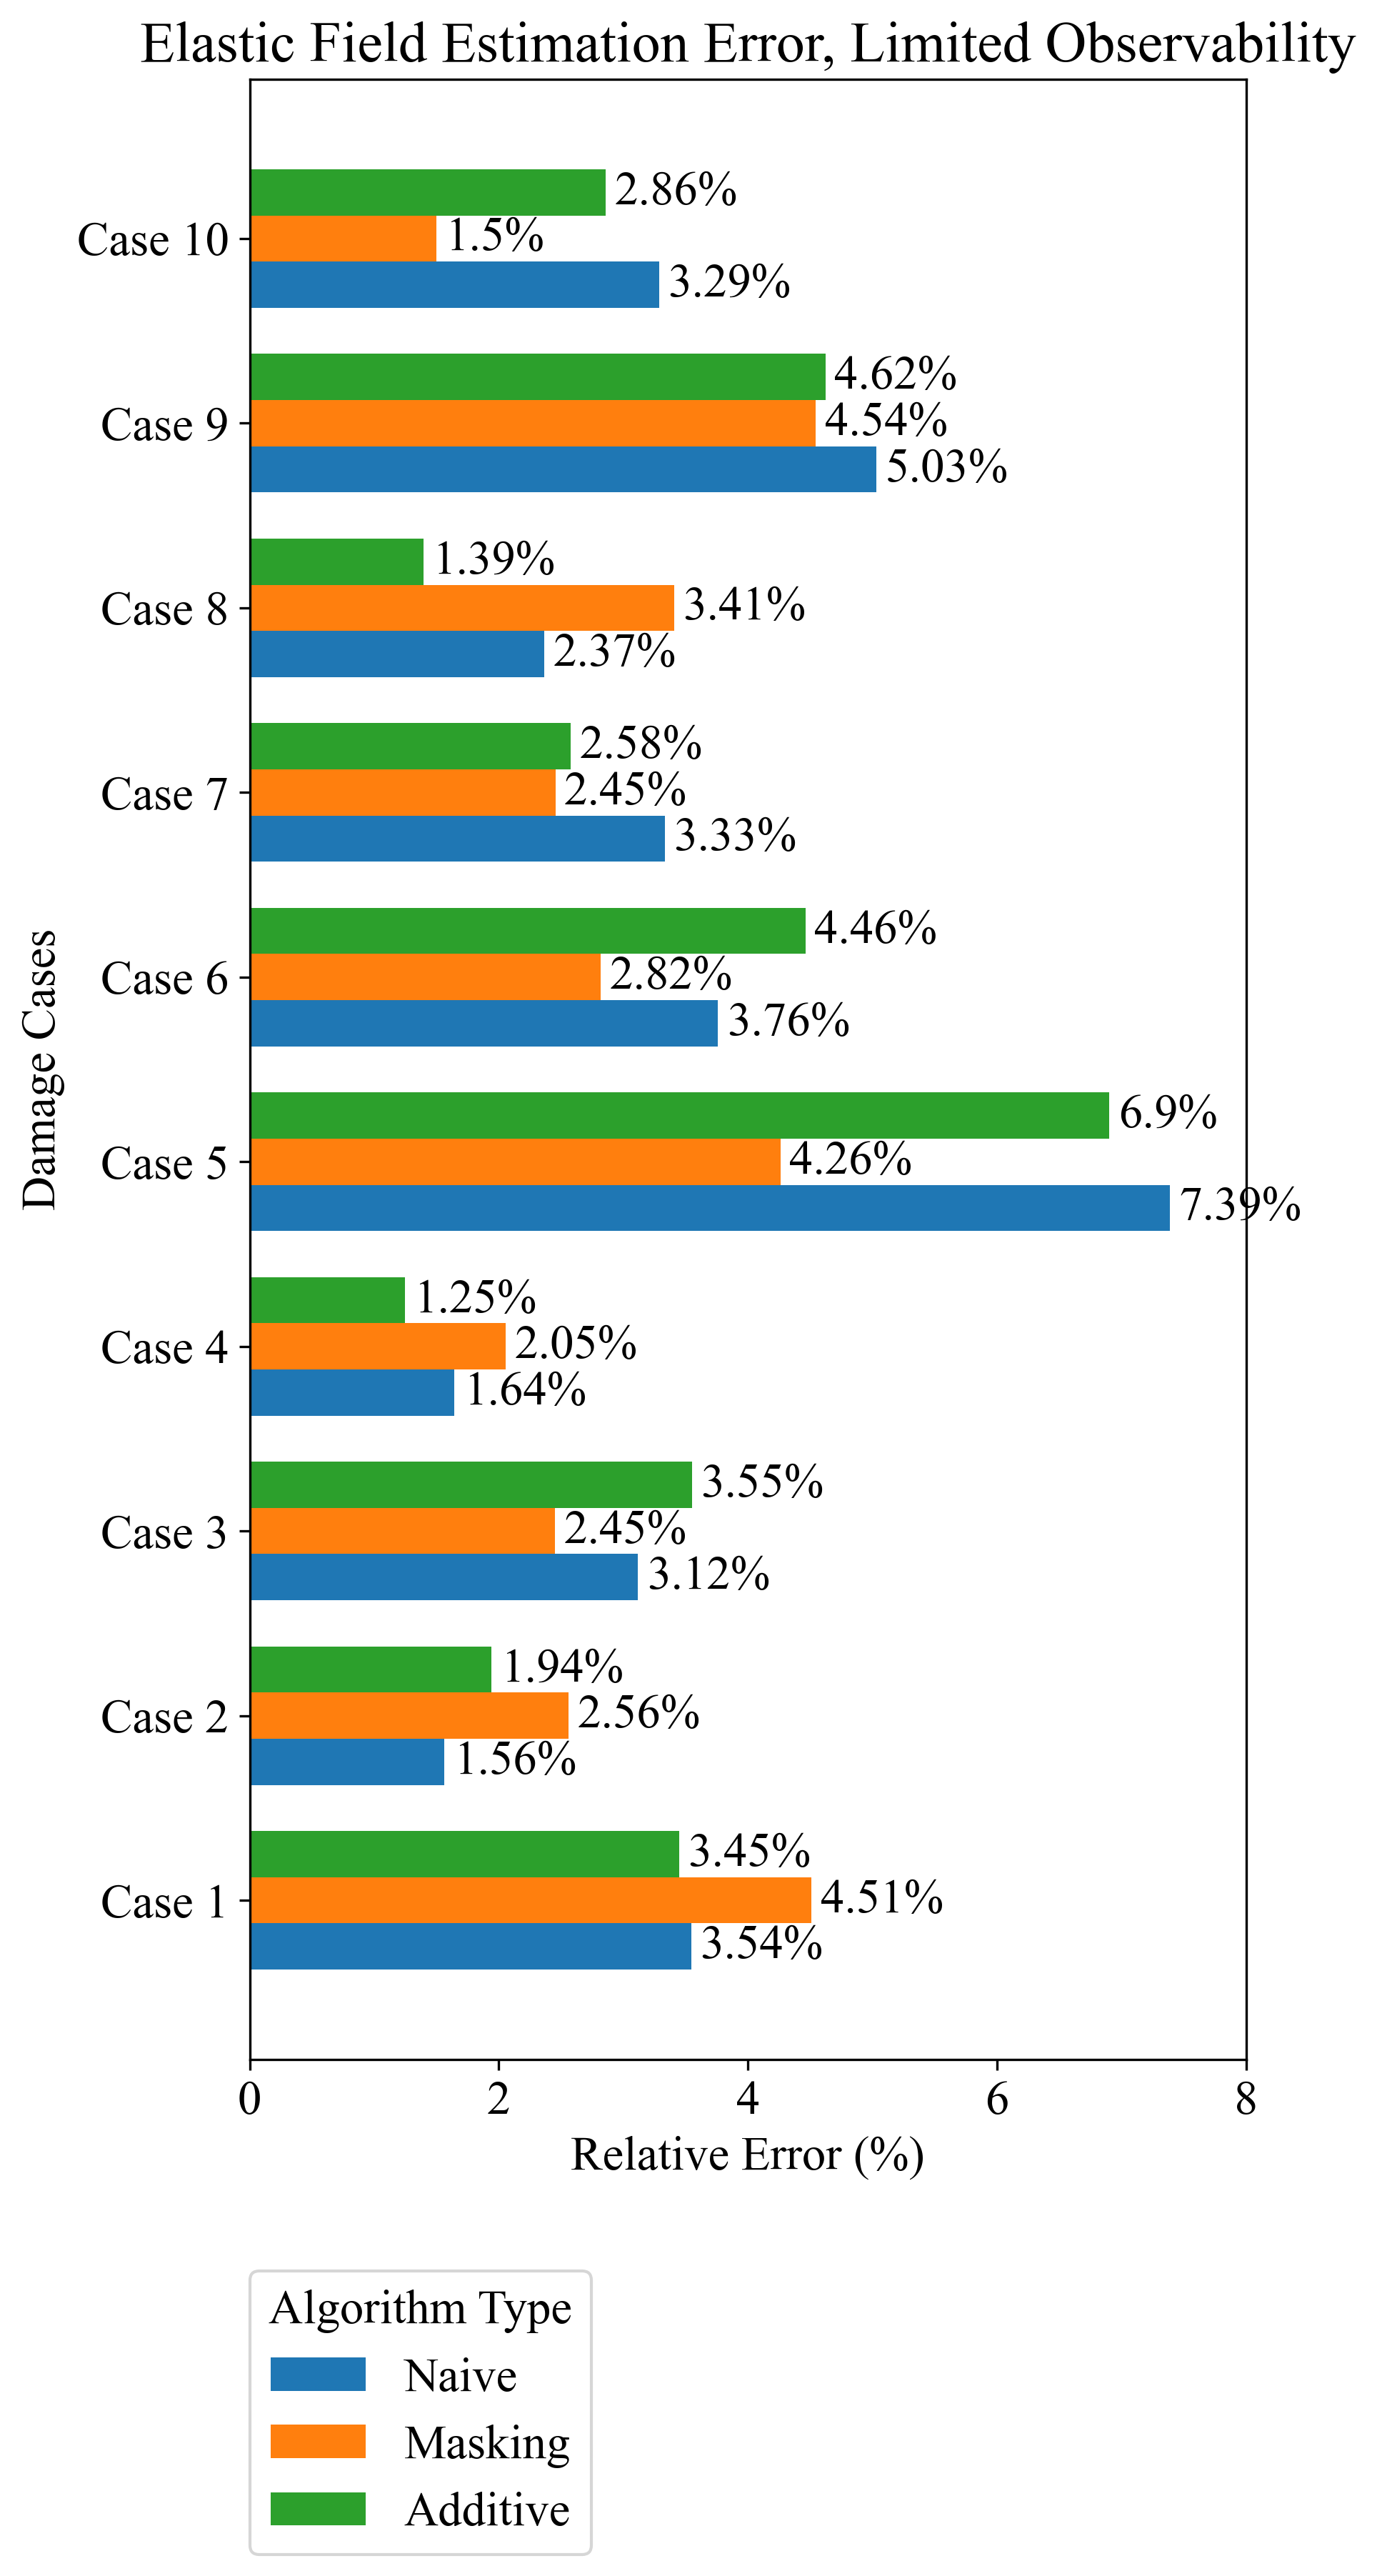

In [105]:
def stable_regions(x, reference, n_percent=10, m=2):
    deviation = (x - reference) ** 2
    n_elements = int(len(deviation) * (n_percent / 100))
    
    # Get indices of the lowest n% deviations
    stable_indices = np.argsort(deviation)[:n_elements]
    
    # Compute the standard deviation of these stable elements
    stable_std = np.std(deviation[stable_indices])
    
    # Identify indices where deviation exceeds m times the stable standard deviation
    threshold = m * stable_std
    exceed_indices = np.where(deviation > threshold)[0]

    return stable_indices, stable_std, exceed_indices

E_trues = [E_d, E_g, E_h, E_v, E_d_m, E_g_m, E_v_m, E_gt, E_gt_m, E_ht]
cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']
obs_choices = ["full", "sensor"]

for obs in obs_choices:
    naive, masking, additive = [], [], []
    for i, case in enumerate(cases):
        with open(f"r_c_{case}_{obs}.json") as json_file:
                result = json.load(json_file)['E_hist'][-1]
        E_true = E_trues[i].flatten()
        error = np.mean(np.abs(np.divide((result - E_true), E_true)))
        naive.append(error)
            

        stable, std, exceed = stable_regions(np.array(result), 4e3, n_percent=50, m=1e3)
        it2 = f"r_c_mask_{case}_{obs}_start_10.json"
        with open(it2) as json_file:
                result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(180*12) + 4e3
        E[exceed] = result
        error = np.mean(np.abs(np.divide((E - E_true), E_true)))
        masking.append(error)

        with open(f"r_c_add_{case}_{obs}_30_p1.json") as json_file:
                result = json.load(json_file)
        E = np.zeros(180*12) + 4e3
        n_locked = len(result["locked_values"])
        E[np.array(result["locked_indices"])] = np.array(result["locked_values"])
        error = np.mean(np.abs(np.divide((E - E_true), E_true)))
        additive.append(error)

    dict_cases = dict(zip(cases, f"case {range(1,len(cases)+1)}"))
    dict_obs = dict(zip(obs_choices, ["Full Observability", 'Limited Observability']))

    species = [f"Case {i+1}" for i in range(len(cases))]
    penguin_means = {
        "Naive" : naive,
        "Masking" : masking,
        "Additive" : additive
    }

    x = np.arange(len(species))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    import matplotlib.pyplot as plt
    import matplotlib
    plt.rcdefaults()
    # matplotlib.rc('text', usetex = True)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['figure.dpi'] = 300
    font = {'size'   : 16}
    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(6,12))
    fmt = '%.2g%%' # Format you want the ticks, e.g. '40%'
    # xticks = mtick.FormatStrFormatter(fmt)
    # ax.xaxis.set_major_formatter(xticks)

    def gray(level):
        return (level, level, level)

    for j, (attribute, measurement) in enumerate(penguin_means.items()):
        offset = width * multiplier
        rects = ax.barh(x + offset, np.array(measurement)*100, width, label=attribute)
        ax.bar_label(rects, padding=3, fmt='%.3g%%')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Relative Error (%)')
    ax.set_title(f'Elastic Field Estimation Error, {dict_obs[obs]}')
    ax.set_yticks(x + width, species)
    ax.legend(loc=(0,-0.25), title="Algorithm Type")
    ax.set_xlim(0, 8)
    ax.set_ylabel('Damage Cases')
    plt.show()

In [25]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]
filenames2 = []
for file in filenames:
    if "mask" not in file:
        filenames2.append(file)
filenames = filenames2

E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 80
Ny = 10
n_particles = Nx * Ny
E_true = np.zeros(n_particles)
E_damaged = np.zeros(n_particles)

pattern = r"_(\d+)_(\d+)_"

def stable_regions(x, reference, n_percent=10, m=2):
    deviation = (x - reference) ** 2
    n_elements = int(len(deviation) * (n_percent / 100))
    
    # Get indices of the lowest n% deviations
    stable_indices = np.argsort(deviation)[:n_elements]
    
    # Compute the standard deviation of these stable elements
    stable_std = np.std(deviation[stable_indices])
    
    # Identify indices where deviation exceeds m times the stable standard deviation
    threshold = m * stable_std
    exceed_indices = np.where(deviation > threshold)[0]

    return stable_indices, stable_std, exceed_indices

for name in filenames:
    print(name)
    with open(name) as json_file:
        result = json.load(json_file)['E_hist'][-1]   
    E = np.zeros(n_particles)
    match = re.search(pattern, name)
    n_blocks_x = 80
    n_blocks_y = 10
    n_blocks = n_blocks_y * n_blocks_x
    block_nx = int(Nx / n_blocks_x)
    block_ny = int(Ny / n_blocks_y)

    for i in range(Nx):
        for j in range(Ny):
            block_index_x = i // block_nx
            block_index_y = j // block_ny
            E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
    E = einops.rearrange(E, "(y x) -> x y", y=Ny)#.transpose()
    
    obs = re.search("_([a-z]+).json", name).group(1)


    fig, axs = plt.subplots(1,1,figsize=(3,1))
    # title = str(n_blocks_x) + ' by ' + str(n_blocks_y) + ", " + obs + " observability"
    title = name


    im = axs.imshow(E.transpose(), origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
    axs.set_title(title)
    divider= make_axes_locatable(axs)
    cax= divider.append_axes("bottom", size="5%", pad=0.3)
    fig.colorbar(im, cax=cax, orientation='horizontal')


    table, std, exceed = stable_regions(np.array(result), 1e4, n_percent=50, m=1e3)
    mask = np.zeros(n_particles)
    mask[exceed] = 100
    mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()

    axs.imshow(mask, origin='lower')

    plt.show()
        

    


result_add_dm_full_5_p1.json


AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
import numpy as np
arr = np.arange(10)
arr2 = np.arange(5)
np.concatenate((arr, arr2))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4])

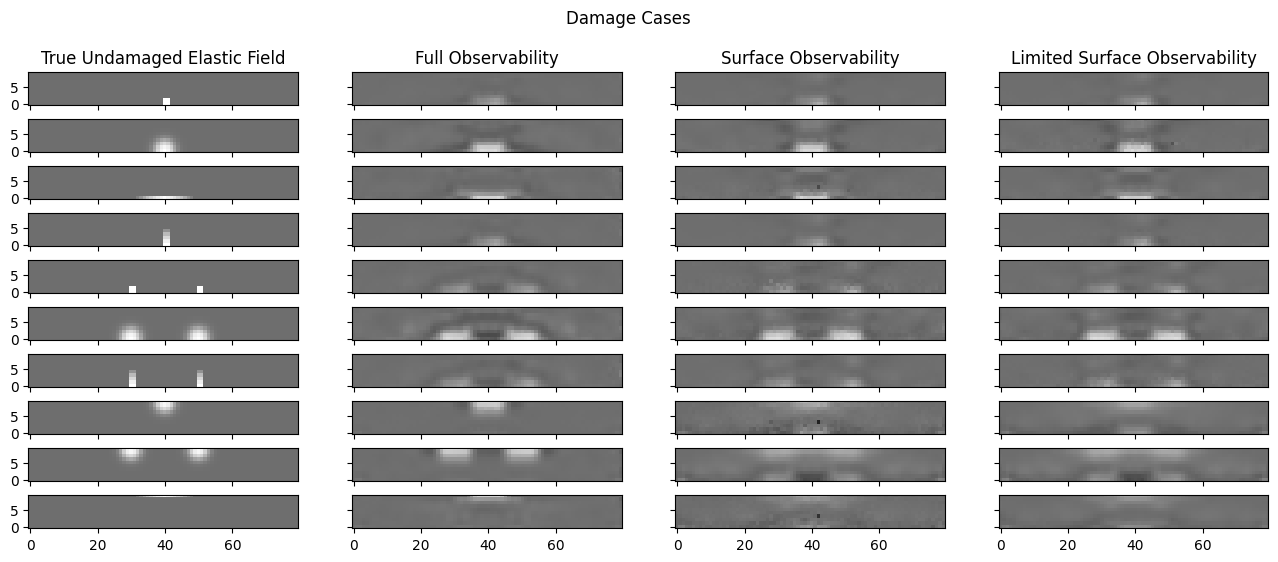

In [24]:
fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


fig.suptitle('Damage Cases')

axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 80
Ny = 10
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

for k, case in enumerate(cases):
    obs_cases = [
        'result_'+case+'_80_10_full.json',
        'result_'+case+'_80_10_row.json',
        'result_'+case+'_80_10_sensor.json'
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(n_particles)
        match = re.search(pattern, name)
        n_blocks_x = 80
        n_blocks_y = 10
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        for i in range(Nx):
            for j in range(Ny):
                block_index_x = i // block_nx
                block_index_y = j // block_ny
                E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[0, 1].set_title('Full Observability')
axs[0, 2].set_title('Surface Observability')
axs[0, 3].set_title('Limited Surface Observability')
plt.show()
    

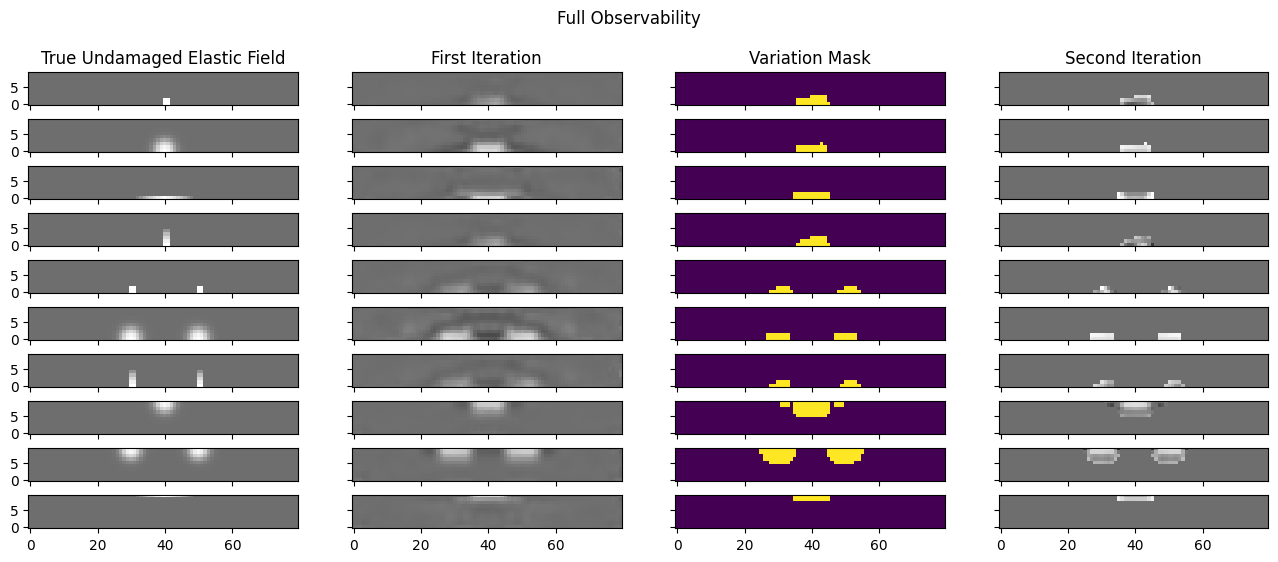

In [23]:
fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


fig.suptitle('Full Observability')

axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 80
Ny = 10
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

def stable_regions(x, reference, n_percent=10, m=2):
    deviation = (x - reference) ** 2
    n_elements = int(len(deviation) * (n_percent / 100))
    
    # Get indices of the lowest n% deviations
    stable_indices = np.argsort(deviation)[:n_elements]
    
    # Compute the standard deviation of these stable elements
    stable_std = np.std(deviation[stable_indices])
    
    # Identify indices where deviation exceeds m times the stable standard deviation
    threshold = m * stable_std
    exceed_indices = np.where(deviation > threshold)[0]

    return stable_indices, stable_std, exceed_indices


for k, case in enumerate(cases):
    obs_cases = [
        'result_'+case+'_80_10_full.json',
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(n_particles)
        match = re.search(pattern, name)
        n_blocks_x = 80
        n_blocks_y = 10
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        for i in range(Nx):
            for j in range(Ny):
                block_index_x = i // block_nx
                block_index_y = j // block_ny
                E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

    stable, std, exceed = stable_regions(np.array(result), 1e4, n_percent=50, m=1e3)
    mask = np.zeros(n_particles)
    mask[exceed] = 100
    mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()
    axs[k, l + 2].imshow(mask, origin='lower')
    
    it2 = 'result_'+case+'_mask_80_10_full_start_100.0.json'
    with open(it2) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
    E = np.zeros(n_particles) + 1e4
    E[exceed] = result
    E_rearrange = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
    axs[k, l + 3].imshow(E_rearrange, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


axs[0, 1].set_title('First Iteration')
axs[0, 2].set_title('Variation Mask')
axs[0, 3].set_title('Second Iteration')
plt.show()




['result_dm_80_10_full.json', 'result_dm_80_10_row.json', 'result_dm_80_10_sensor.json', 'result_dm_mask_80_10_full_start_100.0.json', 'result_dm_mask_80_10_sensor_start_100.0.json', 'result_d_80_10_full.json', 'result_d_80_10_row.json', 'result_d_80_10_sensor.json', 'result_d_mask_80_10_full_start_100.0.json', 'result_d_mask_80_10_sensor_start_100.0.json', 'result_gm_80_10_full.json', 'result_gm_80_10_row.json', 'result_gm_80_10_sensor.json', 'result_gm_mask_80_10_full_start_100.0.json', 'result_gm_mask_80_10_sensor_start_100.0.json', 'result_gtm_80_10_full.json', 'result_gtm_80_10_row.json', 'result_gtm_80_10_sensor.json', 'result_gtm_mask_80_10_full_start_100.0.json', 'result_gtm_mask_80_10_sensor_start_10000.0.json', 'result_gt_80_10_full.json', 'result_gt_80_10_row.json', 'result_gt_80_10_sensor.json', 'result_gt_mask_80_10_full_start_100.0.json', 'result_gt_mask_80_10_sensor_start_10000.0.json', 'result_g_80_10_full.json', 'result_g_80_10_row.json', 'result_g_80_10_sensor.json', 

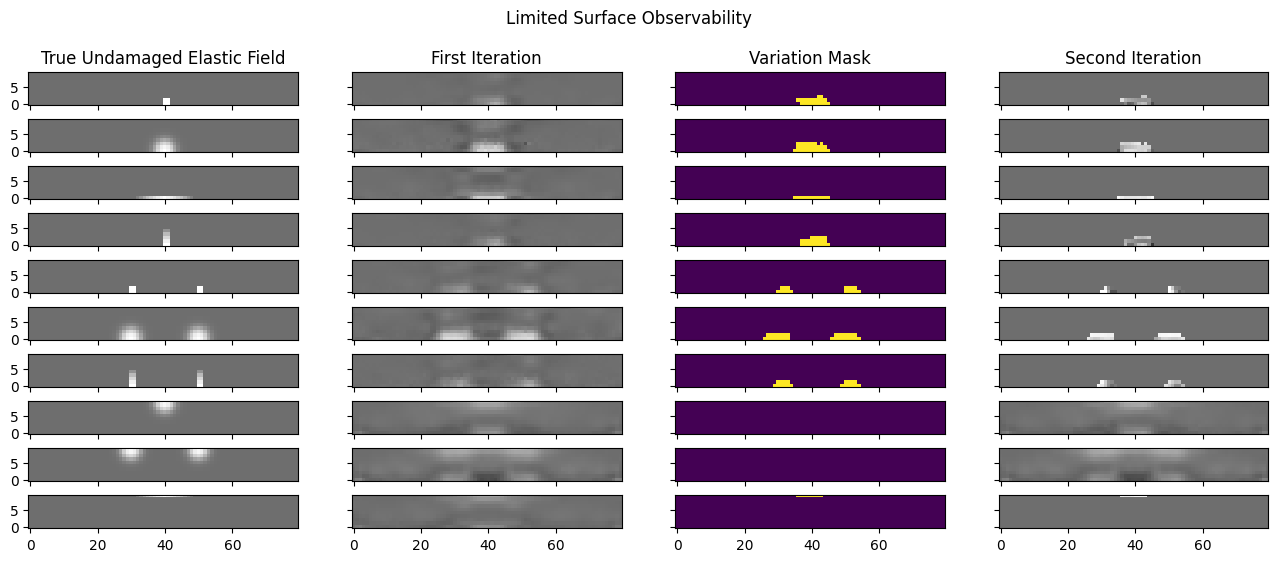

In [22]:
fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


fig.suptitle('Limited Surface Observability')

axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]
filenames2 = []
for file in filenames:
    if "add" not in file:
        filenames2.append(file)
filenames = filenames2
print(filenames)


Nx = 80
Ny = 10
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

def stable_regions(x, reference, n_percent=10, m=2):
    deviation = (x - reference) ** 2
    n_elements = int(len(deviation) * (n_percent / 100))
    
    # Get indices of the lowest n% deviations
    stable_indices = np.argsort(deviation)[:n_elements]
    
    # Compute the standard deviation of these stable elements
    stable_std = np.std(deviation[stable_indices])
    
    # Identify indices where deviation exceeds m times the stable standard deviation
    threshold = m * stable_std
    exceed_indices = np.where(deviation > threshold)[0]

    return stable_indices, stable_std, exceed_indices


for k, case in enumerate(cases):
    obs_cases = [
        'result_'+case+'_80_10_sensor.json',
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(n_particles)
        match = re.search(pattern, name)
        n_blocks_x = 80
        n_blocks_y = 10
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        for i in range(Nx):
            for j in range(Ny):
                block_index_x = i // block_nx
                block_index_y = j // block_ny
                E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

    stable, std, exceed = stable_regions(np.array(result), 1e4, n_percent=50, m=1e3)

    mask = np.zeros(n_particles)
    mask[exceed] = 100
    mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()
    axs[k, l + 2].imshow(mask, origin='lower')
    if len(exceed) == 0:
        it2 = 'result_'+case+'_mask_80_10_sensor_start_10000.0.json'
        with open(it2) as json_file:
            result = json.load(json_file)['E_hist'][-1]
        E = np.array(result) 
        
    else:
        it2 = 'result_'+case+'_mask_80_10_sensor_start_100.0.json'
        with open(it2) as json_file:
            result = json.load(json_file)['E_hist'][-1] 
        E = np.zeros(n_particles) + 1e4
        E[exceed] = result
        

    E_rearrange = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
    axs[k, l + 3].imshow(E_rearrange, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


axs[0, 1].set_title('First Iteration')
axs[0, 2].set_title('Variation Mask')
axs[0, 3].set_title('Second Iteration')
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: 'result_add_gt_sensor_5_p2.json'

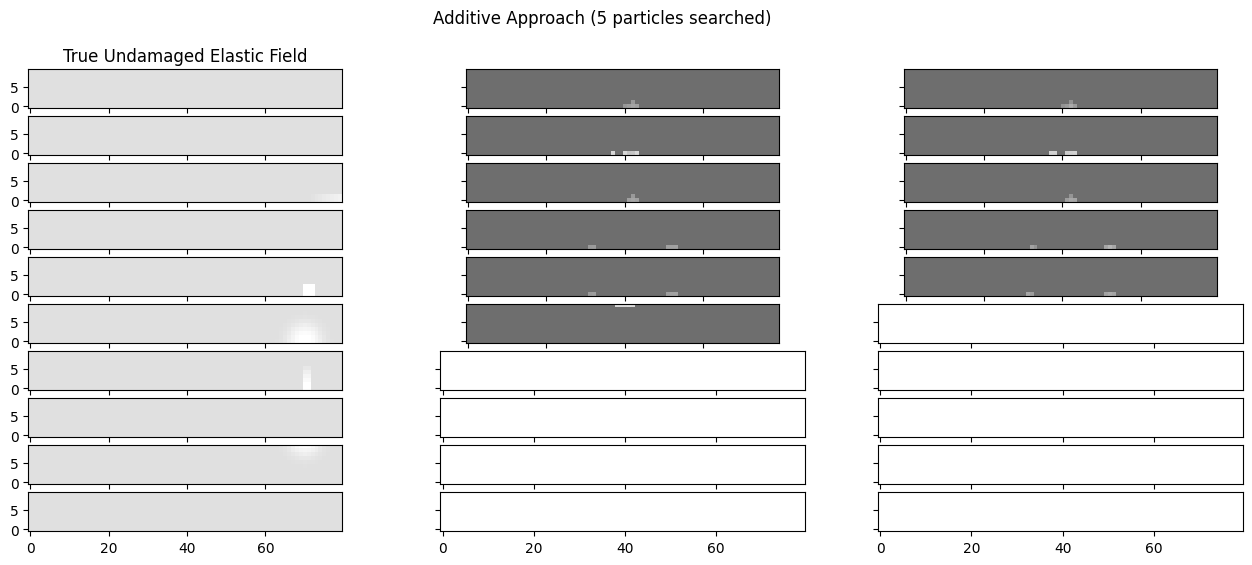

In [35]:
fig, axs = plt.subplots(10,3, sharex=True, sharey=True, figsize=(16,6))


fig.suptitle('Additive Approach (5 particles searched)')

axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]
filenames2 = []
for file in filenames:
    if "add" in file and "p1" in file:
        filenames2.append(file)
filenames = filenames2


Nx = 80
Ny = 10
n_particles = Nx * Ny
init_e = 1e4


for k, case in enumerate(cases):
    obs_cases = [
        'result_add_'+case+'_full_5_p1.json',
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)  
        E = np.zeros(n_particles) + init_e
        n_blocks_x = 80
        n_blocks_y = 10
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        E[np.array(result["locked_indices"])] = np.array(result["locked_values"])
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

    obs_cases = [
        'result_add_'+case+'_sensor_5_p1.json',
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)  
        E = np.zeros(n_particles) + init_e
        n_blocks_x = 80
        n_blocks_y = 10
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        E[np.array(result["locked_indices"])] = np.array(result["locked_values"])
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 2].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

    # mask = np.zeros(n_particles)
    # mask[exceed] = 100
    # mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()
    # axs[k, l + 2].imshow(mask, origin='lower')



axs[0, 1].set_title('Full Observability')
axs[0, 2].set_title('Limited Surface Observability')
# axs[0, 3].set_title('Second Iteration')
plt.show()




result_add_dm_full_5_p1.json


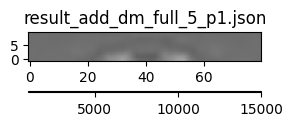

result_add_dm_full_5_p2.json


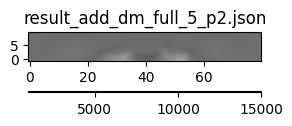

result_add_dm_sensor_5_p1.json


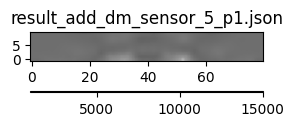

result_add_dm_sensor_5_p2.json


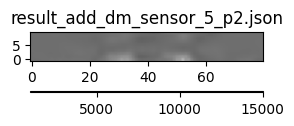

result_add_d_full_5_p1.json


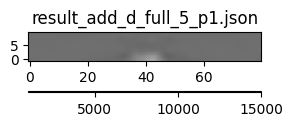

result_add_d_full_5_p2.json


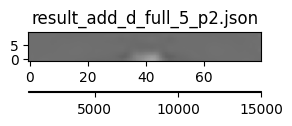

result_add_d_row_5_p1.json


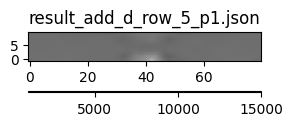

result_add_d_row_5_p2.json


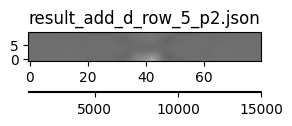

result_add_d_sensor_5_p1.json


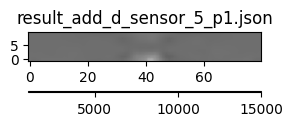

result_add_d_sensor_5_p2.json


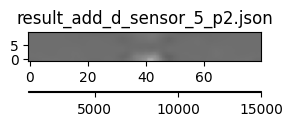

result_add_gm_full_5_p1.json


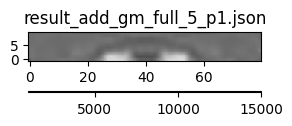

result_add_gm_sensor_5_p1.json


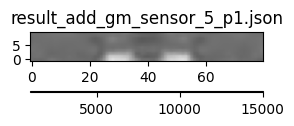

result_add_gtm_full_5_p1.json


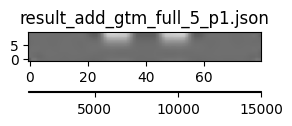

result_add_gtm_full_5_p2.json


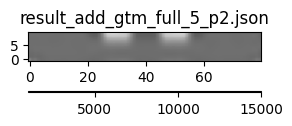

result_add_gtm_sensor_5_p1.json


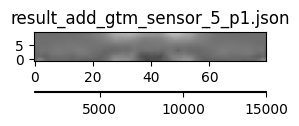

result_add_gtm_sensor_5_p2.json


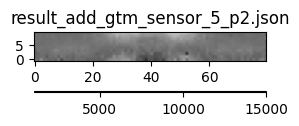

result_add_gt_full_5_p1.json


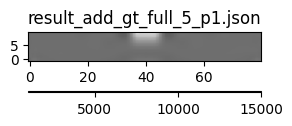

result_add_gt_full_5_p2.json


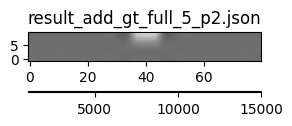

result_add_gt_sensor_5_p1.json


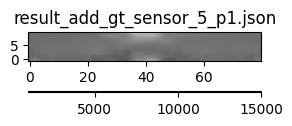

result_add_g_full_5_p1.json


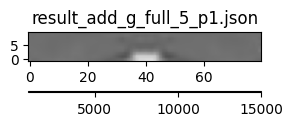

result_add_g_sensor_5_p1.json


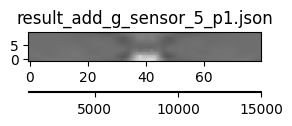

result_add_ht_full_5_p1.json


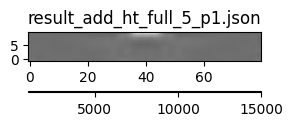

result_add_ht_full_5_p2.json


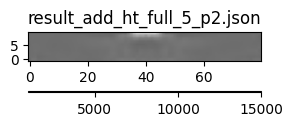

result_add_ht_sensor_5_p1.json


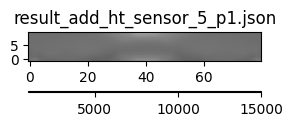

result_add_ht_sensor_5_p2.json


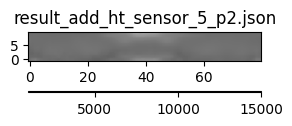

result_add_h_full_5_p1.json


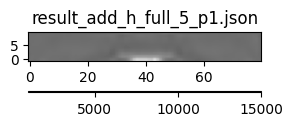

result_add_h_full_5_p2.json


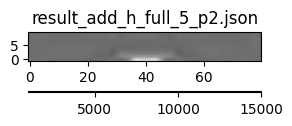

result_add_h_sensor_5_p1.json


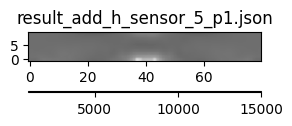

result_add_h_sensor_5_p2.json


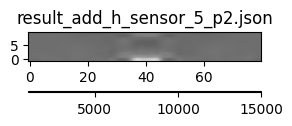

result_add_vm_full_5_p1.json


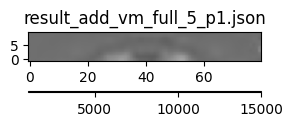

result_add_vm_full_5_p2.json


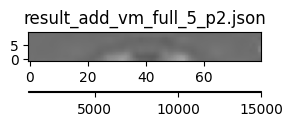

result_add_vm_sensor_5_p1.json


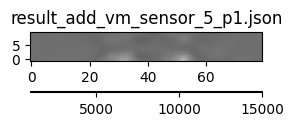

result_add_vm_sensor_5_p2.json


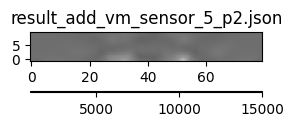

result_add_v_full_5_p1.json


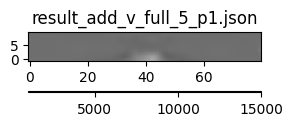

result_add_v_full_5_p2.json


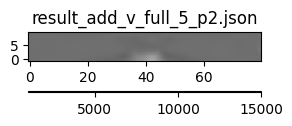

result_add_v_sensor_5_p1.json


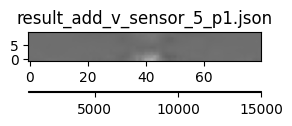

result_add_v_sensor_5_p2.json


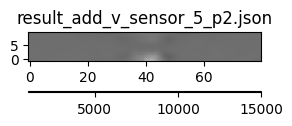

In [ ]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]
filenames2 = []
for file in filenames:
    if "add" in file:
        filenames2.append(file)
filenames = filenames2

E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 80
Ny = 10
n_particles = Nx * Ny
E_true = np.zeros(n_particles)
E_damaged = np.zeros(n_particles)

pattern = r"_(\d+)_(\d+)_"


for name in filenames:
    print(name)
    with open(name) as json_file:
        result = json.load(json_file)['E_hist'][-2]   
    E = np.zeros(n_particles)
    match = re.search(pattern, name)
    n_blocks_x = 80
    n_blocks_y = 10
    n_blocks = n_blocks_y * n_blocks_x
    block_nx = int(Nx / n_blocks_x)
    block_ny = int(Ny / n_blocks_y)

    for i in range(Nx):
        for j in range(Ny):
            block_index_x = i // block_nx
            block_index_y = j // block_ny
            E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
    E = einops.rearrange(E, "(y x) -> x y", y=Ny)#.transpose()
    
    # obs = re.search("_([a-z]+).json", name).group(1)


    fig, axs = plt.subplots(1,1,figsize=(3,1))
    # title = str(n_blocks_x) + ' by ' + str(n_blocks_y) + ", " + obs + " observability"
    title = name


    im = axs.imshow(E.transpose(), origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
    axs.set_title(title)
    divider= make_axes_locatable(axs)
    cax= divider.append_axes("bottom", size="5%", pad=0.3)
    fig.colorbar(im, cax=cax, orientation='horizontal')

    plt.show()
        

    


In [ ]:
with open(name) as json_file:
        result = json.load(json_file)['E_hist']

result[3]

[10155.431640625,
 9960.9208984375,
 9964.7568359375,
 9951.279296875,
 9928.44921875,
 9925.294921875,
 9943.2314453125,
 9962.0361328125,
 9965.4658203125,
 9957.2216796875,
 9946.9609375,
 9936.6689453125,
 9930.7578125,
 9930.8232421875,
 9937.7080078125,
 9956.0224609375,
 9982.392578125,
 10006.369140625,
 10008.4931640625,
 10031.220703125,
 10071.1015625,
 10111.8251953125,
 10138.65234375,
 10162.1904296875,
 10185.787109375,
 10205.6904296875,
 10219.9814453125,
 10244.1259765625,
 10266.6708984375,
 10260.5966796875,
 10251.8876953125,
 10268.2099609375,
 10264.44140625,
 10058.296875,
 9733.2353515625,
 9400.4287109375,
 9037.5439453125,
 8631.4970703125,
 8371.0537109375,
 8214.689453125,
 8002.845703125,
 7654.02392578125,
 7119.90869140625,
 7652.26513671875,
 8277.90625,
 8972.9296875,
 9530.1435546875,
 9987.580078125,
 10255.5498046875,
 10296.6083984375,
 10298.4248046875,
 10338.85546875,
 10386.23046875,
 10371.4873046875,
 10307.2939453125,
 10243.658203125,
 1019